# Project 3: mheight Prediction with Transformers & MoE

## 1. Core Architecture: Transformer-MoE

The backbone of our solution is a **Context-Aware Transformer with a Mixture of Experts (MoE)** head. This architecture was chosen to handle the non-linear complexity of determinant calculation while adapting to the vast differences in difficulty between small matrices ($k=2$) and "Giant" matrices ($k=5, n=9$).

### A. Input Processing
Instead of flattening the matrix immediately, we treat the input as a sequence of row vectors combined with metadata.

* **Matrix Input:** $P \in \mathbb{R}^{6 \times 5}$ (Pad-normalized).

* **Context Token:** A learned embedding combining scalars $n, k, m$. This token is concatenated to the matrix sequence, allowing the attention mechanism to condition its calculations on the global parameters.

### B. Deep Transformer Encoder
We utilize a **6-Layer Transformer Encoder** stack.

* **Self-Attention:** 8 heads per layer allow the model to capture row-wise dependencies and linear combinations critical for determinant calculation.

* **Regularization:** We apply `Dropout(0.05)` and `L2(1e-6)` regularization within the FFN blocks to prevent overfitting on the synthetic data patterns.

### C. Soft-Gated Mixture of Experts (MoE)
Instead of a single dense output head, we employ a Mixture of Experts to specialize in different mathematical "regimes".

* **Router:** A Dense softmax layer that takes the global context vector and assigns a probability distribution $w_i$ over the experts.

* **Experts:** 8 distinct Dense Networks. Each expert is a `Dense(256) -> Dense(128) -> Dense(1)` block.

* **Soft Routing:** The final output is the weighted sum of all expert predictions: $\hat{y} = \sum_{i=1}^{N} w_i \cdot E_i(x)$.

In [ ]:
from tensorflow.keras import mixed_precision
# A100 supports 'mixed_bfloat16'. Use it!
mixed_precision.set_global_policy('mixed_bfloat16')
print("🚀 A100 Mode: Mixed Precision (bfloat16) Enabled")

🚀 A100 Mode: Mixed Precision (bfloat16) Enabled


In [ ]:
!rm -rf tf_dataset/

In [ ]:
!ls

best_submission_model.keras	 X_generated_54k.pkl
input_data_56k.pkl		 X_generated_90k.pkl
output_data_56k.pkl		 y_full_dataset_4.5k_samples.pkl
sample_data			 y_generated_108k.pkl
x_full_dataset_4.5k_samples.pkl  y_generated_45k.pkl
X_generated_108k.pkl		 y_generated_54k.pkl
X_generated_45k.pkl		 y_generated_90k.pkl


# Loading Data

* The training dataset was produced on the Texas A&M HPRC cluster using large-scale LP m-height simulations.  

* It combines the instructor-provided 56k parity-matrix samples with ~190k additional high-resolution configurations generated through custom HPC batch jobs.  

* Together, these datasets form a diverse and computationally intensive corpus that captures a wide range of parity structures for robust model training.


In [ ]:
import os
import sys
import json
import pickle
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

DATA_SOURCES = [
    ("train_data/input_data_56k.pkl", "train_data/output_data_56k.pkl", "Instructor_56k", True),
    ("train_data/X_generated_45k.pkl", "train_data/y_generated_45k.pkl", "Generated_45k", False),
    ("train_data/X_generated_54k.pkl", "train_data/y_generated_54k.pkl", "Generated_54k", False),
    ("train_data/X_generated_90k.pkl", "train_data/y_generated_90k.pkl", "Generated_90k", False),
    ("train_data/X_generated_108k.pkl", "train_data/y_generated_108k.pkl", "Generated_108k", False),
]

OUTPUT_DIR = "tf_dataset"
P_ROWS = 6  # Max k
P_COLS = 5  # Max n-k (9-4)
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# ==========================================
# 2. UTILITIES
# ==========================================
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def serialize_example(n, k, m, P_flat, y):
    feature = {
        'n': _float_feature([n]),
        'k': _float_feature([k]),
        'm': _float_feature([m]),
        'P_flat': _float_feature(P_flat),
        'y': _float_feature([y]),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

def load_source_pkl(feat_path, label_path, tag, required=False):
    if not os.path.exists(feat_path) or not os.path.exists(label_path):
        if required: raise FileNotFoundError(f"Missing: {feat_path}")
        print(f"⚠️  Skipping {tag}")
        return [], [], []

    print(f"📦 Loading {tag}...", end=" ")
    with open(feat_path, "rb") as f: X_raw = pickle.load(f)
    with open(label_path, "rb") as f: y_raw = pickle.load(f)

    P_list, scalar_list = [], []
    for item in X_raw:
        n, k, m, P_mat = item
        # Pad P immediately to fixed 6x5
        P_pad = np.zeros((P_ROWS, P_COLS), dtype=np.float32)
        r = min(len(P_mat), P_ROWS)
        c = min(len(P_mat[0]) if len(P_mat)>0 else 0, P_COLS)
        P_pad[:r, :c] = np.array(P_mat, dtype=np.float32)[:r, :c]

        P_list.append(P_pad)
        scalar_list.append([n, k, m])

    print(f"✅ {len(P_list)}")
    return np.array(P_list, dtype=np.float32), np.array(scalar_list, dtype=np.float32), np.array(y_raw, dtype=np.float32)

# ==========================================
# 3. EXECUTION
# ==========================================
print("🚀 STARTING CONVERSION")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# A. Aggregate
all_P, all_scalars, all_y = [], [], []
for feat, lbl, tag, req in DATA_SOURCES:
    P, S, Y = load_source_pkl(feat, lbl, tag, req)
    if len(P) > 0:
        all_P.append(P)
        all_scalars.append(S)
        all_y.append(Y)

if not all_P: raise RuntimeError("No data loaded!")

X_P_final = np.concatenate(all_P, axis=0)
X_scalars_final = np.concatenate(all_scalars, axis=0)
y_final = np.concatenate(all_y, axis=0)

# B. Splits
indices = np.arange(len(y_final))
train_val_idx, test_idx = train_test_split(indices, test_size=0.1, random_state=SEED)
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.1111, random_state=SEED)


# C. Statistics (Standard Scaling) - TRAIN ONLY
print("🧮 Computing Normalization Stats (Train Only)...")

# We collect ONLY valid pixels to compute global mean/std
valid_pixels = []

for i in train_idx:
    n, k, m = X_scalars_final[i]
    p_matrix = X_P_final[i] # Shape (6, 5)

    valid_rows = int(k)      # k rows
    valid_cols = int(n - k)  # n-k columns

    # Extract only the valid sub-matrix
    # Clip first to match document specs [-100, 100]
    valid_data = np.clip(p_matrix[:valid_rows, :valid_cols], -100.0, 100.0)
    valid_pixels.append(valid_data.flatten())

# Concatenate all valid pixels into one giant array for robust global stats
flat_valid_pixels = np.concatenate(valid_pixels)

# Compute Scalar Mean/Var (Applied globally to all pixels)
# Using scalar stats is safer than vector stats for variable sized matrices
global_mean = np.mean(flat_valid_pixels)
global_var = np.var(flat_valid_pixels)

# Replicate to vector shape for compatibility with your existing pipeline
mean_vec = np.full((P_ROWS * P_COLS,), global_mean)
var_vec = np.full((P_ROWS * P_COLS,), global_var)

print(f"   Global Mean: {global_mean:.4f}, Global Std: {np.sqrt(global_var):.4f}")
print("Done.")

# D. Write TFRecords
splits = {
    "train": (train_idx, os.path.join(OUTPUT_DIR, "train.tfrecord")),
    "val": (val_idx, os.path.join(OUTPUT_DIR, "val.tfrecord")),
    "test": (test_idx, os.path.join(OUTPUT_DIR, "test.tfrecord"))
}

for split_name, (idx_list, filename) in splits.items():
    print(f"   Writing {split_name} ({len(idx_list)} samples)...", end=" ")
    with tf.io.TFRecordWriter(filename) as writer:
        for i in idx_list:
            n, k, m = X_scalars_final[i]
            P_flat = X_P_final[i].flatten()
            y = y_final[i]
            writer.write(serialize_example(n, k, m, P_flat, y))
    print("Done.")

# E. Save Sidecar JSON
unique_ks = sorted(list(set(X_scalars_final[:, 1].astype(int))))
max_m = int(np.max(X_scalars_final[:, 2]))

metadata = {
    "mean": mean_vec.tolist(),
    "variance": var_vec.tolist(),
    "max_m": max_m,
    "unique_ks": [int(k) for k in unique_ks],
    "p_rows": P_ROWS,
    "p_cols": P_COLS,
    "counts": {
        "train": len(train_idx),
        "val": len(val_idx),
        "test": len(test_idx)
    }
}

with open(os.path.join(OUTPUT_DIR, "dataset_info.json"), "w") as f:
    json.dump(metadata, f, indent=2)

print(f"✅ CONVERSION COMPLETE. Data in '{OUTPUT_DIR}/'")

🚀 STARTING CONVERSION
📦 Loading Instructor_56k... ✅ 56365
📦 Loading Generated_45k... ✅ 45000
📦 Loading Generated_54k... ✅ 54000
📦 Loading Generated_90k... ✅ 90000
📦 Loading Generated_108k... ✅ 198000
🧮 Computing Normalization Stats (Train Only)...
   Global Mean: -0.0061, Global Std: 55.4608
Done.
   Writing train (354695 samples)... Done.
   Writing val (44333 samples)... Done.
   Writing test (44337 samples)... Done.
✅ CONVERSION COMPLETE. Data in 'tf_dataset/'


# Setup

In [ ]:
import tensorflow as tf
import os
import json
import numpy as np

# ==========================================
# 1. SETUP & CONSTANTS
# ==========================================
AUGMENT_FACTOR = 10
OUTPUT_DIR = "tf_dataset"

# Load Metadata
with open(os.path.join(OUTPUT_DIR, "dataset_info.json"), "r") as f:
    META = json.load(f)

MEAN_CONST = tf.constant(META["mean"], dtype=tf.float32)
STD_CONST = tf.sqrt(tf.constant(META["variance"], dtype=tf.float32))

# ==========================================
# 2. AUGMENTATION LOGIC (FIXED SIGN FLIPS)
# ==========================================
def augment_matrix_tf(P_flat, k, n):
    """
    Applies Column Permutation and Sign Flips ONLY to valid columns.
    Fixes 'Sign Flip on Padding' bug.
    """
    # 1. Recover Matrix Structure
    P_mat = tf.reshape(P_flat, (META["p_rows"], META["p_cols"]))

    # 2. Determine Valid Dimensions
    valid_cols = tf.cast(n - k, tf.int32)

    # 3. Split into Valid vs Padding for Shuffling
    P_T = tf.transpose(P_mat) # Now (5, 6)

    # Create indices for shuffling ONLY the valid range
    valid_indices = tf.range(valid_cols)
    shuffled_valid = tf.random.shuffle(valid_indices)

    # Join shuffled valid indices with static padding indices
    padding_indices = tf.range(valid_cols, META["p_cols"])
    final_indices = tf.concat([shuffled_valid, padding_indices], axis=0)

    # Apply Shuffle (Gather columns based on new indices)
    P_T_shuffled = tf.gather(P_T, final_indices)

    # 4. Sign Flips (Masked)
    # Generate random signs ONLY for valid cols
    valid_signs = tf.random.uniform((valid_cols, 1), minval=0, maxval=2, dtype=tf.int32)
    valid_signs = tf.cast(valid_signs, tf.float32) * 2.0 - 1.0

    # Force padding signs to be 1.0 (No Flip)
    padding_count = META["p_cols"] - valid_cols
    padding_signs = tf.ones((padding_count, 1), dtype=tf.float32)

    # Concat to get (5, 1) vector
    final_signs = tf.concat([valid_signs, padding_signs], axis=0)

    # Apply signs
    P_aug_T = P_T_shuffled * final_signs

    # 5. Transpose back to (6, 5)
    P_aug = tf.transpose(P_aug_T)

    return tf.reshape(P_aug, [META["p_rows"] * META["p_cols"]])

# ==========================================
# 3. PIPELINE MAPPING
# ==========================================
def parse_tfrecord(example_proto):
    feature_desc = {
        'n': tf.io.FixedLenFeature([1], tf.float32),
        'k': tf.io.FixedLenFeature([1], tf.float32),
        'm': tf.io.FixedLenFeature([1], tf.float32),
        'P_flat': tf.io.FixedLenFeature([META["p_rows"] * META["p_cols"]], tf.float32),
        'y': tf.io.FixedLenFeature([1], tf.float32),
    }
    parsed = tf.io.parse_single_example(example_proto, feature_desc)
    return parsed['n'], parsed['k'], parsed['m'], parsed['P_flat'], parsed['y']

def process_sample(n, k, m, P_flat, y, augment=False):
    P_clipped = tf.clip_by_value(P_flat, -100.0, 100.0)
    P_norm = (P_clipped - MEAN_CONST) / STD_CONST

    if augment:
        P_norm = augment_matrix_tf(P_norm, k[0], n[0])

    P_final = tf.reshape(P_norm, (META["p_rows"], META["p_cols"]))

    k_int = tf.cast(k, tf.int32)[0]
    k_vec = tf.one_hot(k_int, depth=7)

    m_int = tf.cast(m, tf.int32)[0]
    m_vec = tf.one_hot(m_int, depth=META["max_m"] + 1)

    inputs = {
        "P_input": P_final,
        "k_input": k_vec,
        "m_input": m_vec,
        "n_input": n
    }

    y_safe = tf.maximum(y, 1.0)
    y_target = tf.math.log(y_safe) / tf.math.log(2.0)

    return inputs, y_target[0]

# ==========================================
# 4. DATASET FACTORY
# ==========================================
def get_dataset(split_name, batch_size=32):
    filename = os.path.join(OUTPUT_DIR, f"{split_name}.tfrecord")
    dataset = tf.data.TFRecordDataset(filename)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

    if split_name == "train":
        dataset = dataset.shuffle(2048)
        dataset = dataset.repeat()
        dataset = dataset.map(lambda n,k,m,p,y: process_sample(n,k,m,p,y, augment=True),
                              num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(lambda n,k,m,p,y: process_sample(n,k,m,p,y, augment=False),
                              num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

print("✅ Data Pipeline Fix Applied: Padding Signs are now locked to 1.0.")

✅ Data Pipeline Fix Applied: Padding Signs are now locked to 1.0.


In [ ]:
print(f"🔬 Verifying Pipeline (Augment Factor: {AUGMENT_FACTOR})")

# Grab a batch
train_ds = get_dataset("train", batch_size=4)

for inputs, targets in train_ds.take(1):
    P_batch = inputs['P_input'].numpy()
    k_batch = inputs['k_input'].numpy()

    for i in range(len(P_batch)):
        k_val = np.argmax(k_batch[i])
        n_val = 9
        valid_cols = n_val - k_val

        print(f"\n--- Sample {i} (k={k_val}, Valid Cols={valid_cols}) ---")

        mat = P_batch[i]
        active_slice = mat[:, :valid_cols]
        padding_slice = mat[:, valid_cols:]

        print(f"   Active Area Mean:  {np.mean(active_slice):.4f}")

        # FIX: Handle empty padding slice for k=4 (Full Matrix)
        if padding_slice.size == 0:
            print("   ✅ Padding Integrity: N/A (Full Width Matrix, No Padding)")
        else:
            unique_padding_vals = np.unique(np.round(padding_slice, 5))

            if len(unique_padding_vals) == 1:
                # Check consistency
                print(f"   ✅ Padding Integrity: Intact (All values = {unique_padding_vals[0]})")
            else:
                print(f"   ❌ Padding Integrity: BROKEN (Values: {unique_padding_vals})")

        print(f"   Target (Log2): {targets.numpy()[i]:.4f}")

🔬 Verifying Pipeline (Augment Factor: 10)

--- Sample 0 (k=6, Valid Cols=3) ---
   Active Area Mean:  -0.2164
   ✅ Padding Integrity: Intact (All values = 0.00011000000085914508)
   Target (Log2): 8.6886

--- Sample 1 (k=4, Valid Cols=5) ---
   Active Area Mean:  -0.0168
   ✅ Padding Integrity: N/A (Full Width Matrix, No Padding)
   Target (Log2): 5.9296

--- Sample 2 (k=6, Valid Cols=3) ---
   Active Area Mean:  0.4468
   ✅ Padding Integrity: Intact (All values = 0.00011000000085914508)
   Target (Log2): 9.9385

--- Sample 3 (k=5, Valid Cols=4) ---
   Active Area Mean:  -0.0196
   ✅ Padding Integrity: Intact (All values = 0.00011000000085914508)
   Target (Log2): 7.7455


In [ ]:
!ls tf_dataset

dataset_info.json  test.tfrecord  train.tfrecord  val.tfrecord


In [ ]:
tf.__version__

'2.19.0'

# MODEL DEFINITION

###  **Model Overview: Soft-Gated Transformer Mixture-of-Experts (MoE)**

This architecture combines **Transformer-based contextual encoding** with a **Mixture-of-Experts (MoE)** system to predict the LP *m-height* value of a parity matrix configuration.

The model first extracts structural and contextual information using a **deep multi-layer Transformer**, then compresses the representation via **Global Max Pooling** to detect key geometric patterns. This pooled context vector feeds into two parallel components:

* a **Gating Network** that produces soft routing weights, and
* an **Experts Block** consisting of *seven independent fully-connected experts*.

The final prediction is obtained by a **soft weighted combination** of expert outputs, enabling specialization across different matrix regimes while maintaining stability and smoothness.



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Concatenate, Dropout, Reshape, MultiHeadAttention,
    LayerNormalization, GlobalMaxPooling1D, Add, Activation, Dot, Flatten
)
from tensorflow.keras.regularizers import l2
from keras.saving import register_keras_serializable
import json
import os


# Custom Metric/Loss for Saving
@register_keras_serializable()
def log2mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

@register_keras_serializable()
def clamp_log2_min_zero(z):
    return tf.maximum(z, 0.0)

def build_transformer_moe(meta_path):
    with open(meta_path, "r") as f:
        meta = json.load(f)
    p_rows, p_cols, max_m = meta["p_rows"], meta["p_cols"], meta["max_m"]

    # --- Inputs ---
    P_input = Input(shape=(p_rows, p_cols), name="P_input")
    m_input = Input(shape=(max_m + 1,), name="m_input")
    k_input = Input(shape=(7,), name="k_input")
    n_input = Input(shape=(1,), name="n_input")

    # --- 1. Feature Extraction (Deep & Context Aware) ---
    # use_bias=False is crucial for zero-padded rows
    x_p = Dense(128, activation="gelu", use_bias=False, name="P_proj")(P_input)

    # Inject Context (k, m) directly into the stream
    context_raw = Concatenate()([m_input, k_input, n_input])
    context_emb = Dense(128, activation="gelu", name="context_proj")(context_raw)
    context_token = Reshape((1, 128))(context_emb)
    x = Concatenate(axis=1)([x_p, context_token])

    # --- 2. Deep Transformer (INCREASED DEPTH) ---
    # Changed loop from 4 to 6 layers
    for i in range(6):
        x_norm = LayerNormalization(epsilon=1e-6)(x)
        attn = MultiHeadAttention(num_heads=8, key_dim=64)(x_norm, x_norm)
        x = Add()([x, attn])

        x_norm = LayerNormalization(epsilon=1e-6)(x)
        ffn = Dense(256, activation="gelu", kernel_regularizer=l2(1e-6))(x_norm)

        # LOWERED DROPOUT from 0.1 to 0.05 inside Transformer
        ffn = Dropout(0.05)(ffn)
        ffn = Dense(128, kernel_regularizer=l2(1e-6))(ffn)
        x = Add()([x, ffn])

    # --- 3. Max Pooling (Singularity Detection) ---
    # Max Pool is better than Average Pool for detecting "existence" of features
    x = LayerNormalization(epsilon=1e-6)(x)
    context = GlobalMaxPooling1D()(x)

    # Explicitly feed context to experts
    expert_input = Concatenate()([context, m_input, n_input])

    # --- 4. Gating Network (The "Manager") ---
    # Decides which expert to trust based on input context
    router_input = Concatenate()([expert_input, k_input])
    gating_weights = Dense(7, activation='softmax', name="soft_router")(router_input)
    gating_weights = Reshape((1, 7), name="gating_reshape")(gating_weights)

    # --- 5. The Experts (LOWER DROPOUT) ---
    experts = []
    for i in range(7):
        e = Dense(256, activation='gelu', kernel_regularizer=l2(4e-5))(expert_input)

        # LOWERED DROPOUT from 0.25 to 0.2
        e = Dropout(0.2)(e)

        e = Dense(128, activation='gelu', kernel_regularizer=l2(4e-5))(e)
        e = Dropout(0.1)(e)

        out = Dense(1, dtype='float32')(e)
        experts.append(out)

    # --- 6. Soft Routing (Weighted Sum) ---
    concat_experts = Concatenate(axis=1)(experts)
    stacked_experts = Reshape((7, 1))(concat_experts)

    # Dot Product: Sum(Weight_i * Prediction_i)
    combined_pred = Dot(axes=(2, 1), name="soft_routing_dot")([gating_weights, stacked_experts])

    # Output
    log2_y_pred = Activation(clamp_log2_min_zero)(Flatten()(combined_pred))

    return Model(inputs=[P_input, m_input, k_input, n_input], outputs=log2_y_pred)

print("✅ Model Architecture Ready: Soft-Gated MoE (Deep + MaxPool)")

✅ Model Architecture Ready: Soft-Gated MoE (Deep + MaxPool)


# FINAL TRAINING RUN (OPTIMIZED FOR A100)

In [ ]:
import os
import json
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# --- 1. CONFIGURATION ---
BATCH_SIZE = 1024       # 🚀 A100 Sweet Spot (Fastest throughput)
AUGMENT_FACTOR = 8      # High data variety (creates ~2M samples per epoch)
EPOCHS = 150            # Extended duration to allow deep convergence
START_LR = 1e-3         # Scaled up for larger batch size (Linear Scaling Rule)

OUTPUT_DIR = "tf_dataset"
MODEL_FILENAME = "best_submission_model.keras"

# Load Metadata
with open(os.path.join(OUTPUT_DIR, "dataset_info.json"), "r") as f:
    meta = json.load(f)

# Calculate Steps
num_train = meta["counts"]["train"] * AUGMENT_FACTOR
num_val = meta["counts"]["val"]
STEPS_PER_EPOCH = num_train // BATCH_SIZE
VALIDATION_STEPS = num_val // BATCH_SIZE

print(f"🚀 TRAINING CONFIGURATION")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Augment Factor: {AUGMENT_FACTOR}x")
print(f"   Steps Per Epoch: {STEPS_PER_EPOCH}")
print(f"   Target LR: {START_LR}")

# --- 2. Gentle Weighting Strategy ---
# Reduces bias by not panicking too much on Giants
def add_sample_weights(inputs, y_target):
    # Weight range: 1.0 (Small) to ~2.1 (Giant)
    # Allows model to focus on hard samples without exploding gradients
    weights = 1.0 + (y_target * 0.05)
    return inputs, y_target, weights

def get_weighted_dataset(split_name, batch_size):
    # Assumes get_dataset is defined in previous cells
    ds = get_dataset(split_name, batch_size)
    if split_name == "train":
        ds = ds.map(add_sample_weights, num_parallel_calls=tf.data.AUTOTUNE)
    return ds

# --- 3. Build & Compile ---
strategy = tf.distribute.MirroredStrategy()
print(f"   GPUs Detected: {strategy.num_replicas_in_sync}")

with strategy.scope():
    # Re-build model to ensure clean state
    model = build_transformer_moe(os.path.join(OUTPUT_DIR, "dataset_info.json"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=START_LR),
        loss=log2mse,
        metrics=['mae']
    )

    # Optional: Print summary to check parameter count
    # model.summary()

# --- 4. Callbacks (Stabilized) ---
callbacks = [
    # 1. Save ONLY the best model (Lowest Val Loss)
    ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, MODEL_FILENAME),
        monitor='val_loss', save_best_only=True, mode='min', verbose=1
    ),
    # 2. Drop LR if stuck. Increased patience to 6 to handle A100 batch variance.
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1
    ),
    # 3. Stop if no improvement. Increased patience to 15.
    EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True, verbose=1
    )
]

# print("\n🚀 STARTING FINAL TRAINING...")
# history = model.fit(
#     get_weighted_dataset("train", BATCH_SIZE),
#     validation_data=get_dataset("val", BATCH_SIZE),
#     epochs=EPOCHS,
#     steps_per_epoch=STEPS_PER_EPOCH,
#     validation_steps=VALIDATION_STEPS,
#     callbacks=callbacks,
#     verbose=1
# )

🚀 TRAINING CONFIGURATION
   Batch Size: 1024
   Augment Factor: 8x
   Steps Per Epoch: 2771
   Target LR: 0.001
   GPUs Detected: 1


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ m_input             │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ k_input             │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ n_input             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 14)        │          0 │ m_input[0][0],    │
│ (Concatenate)       │                   │            │ k_input[0][0],    │
│                     │                   │            │ n_input[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ P_input             │ (None, 6, 5)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_proj        │ (None, 128)       │      1,920 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ P_proj (Dense)      │ (None, 6, 128)    │        640 │ P_input[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 128)    │          0 │ context_proj[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 7, 128)    │          0 │ P_proj[0][0],     │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 7, 128)    │        256 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 128)    │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 7, 128)    │          0 │ concatenate_1[0]… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 128)    │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 7, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 7, 256)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7, 128)    │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 7, 128)    │          0 │ add[0][0],        │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 128)    │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 2,460,144 (9.38 MB)

 Trainable params: 2,460,144 (9.38 MB)

 Non-trainable params: 0 (0.00 B)

# INDEPENDENT EVALUATION PIPELINE (4.5k sample size)

In [ ]:
!ls tf_dataset/

dataset_info.json  test.tfrecord  train.tfrecord  val.tfrecord


In [ ]:
!pwd

/content


In [ ]:
!ls -la

total 114116
drwxr-xr-x 1 root root     4096 Dec  6 22:47 .
drwxr-xr-x 1 root root     4096 Dec  6 22:37 ..
-rw-r--r-- 1 root root 30056338 Dec  6 22:39 best_submission_model.keras
drwxr-xr-x 4 root root     4096 Nov 20 14:30 .config
-rw-r--r-- 1 root root  5398227 Dec  6 22:39 input_data_56k.pkl
-rw-r--r-- 1 root root   750378 Dec  6 22:39 output_data_56k.pkl
drwxr-xr-x 1 root root     4096 Nov 20 14:30 sample_data
drwxr-xr-x 2 root root     4096 Dec  6 22:47 tf_dataset
-rw-r--r-- 1 root root   893247 Dec  6 22:39 x_full_dataset_4.5k_samples.pkl
-rw-r--r-- 1 root root 38590943 Dec  6 22:39 X_generated_108k.pkl
-rw-r--r-- 1 root root  8931434 Dec  6 22:39 X_generated_45k.pkl
-rw-r--r-- 1 root root 10717695 Dec  6 22:39 X_generated_54k.pkl
-rw-r--r-- 1 root root 17862748 Dec  6 22:39 X_generated_90k.pkl
-rw-r--r-- 1 root root    40524 Dec  6 22:38 y_full_dataset_4.5k_samples.pkl
-rw-r--r-- 1 root root  1866988 Dec  6 22:39 y_generated_108k.pkl
-rw-r--r-- 1 root root   405158 Dec  6 22:3

In [ ]:
# ==========================================
# CELL 5: INDEPENDENT EVALUATION PIPELINE
# ==========================================
import os
import pickle
import json
import numpy as np
import tensorflow as tf
from keras.saving import register_keras_serializable

# --- 1. CONFIGURATION ---
INPUT_PATH      = "test_data/x_full_dataset_4.5k_samples.pkl"
OUTPUT_PATH     = "test_data/y_full_dataset_4.5k_samples.pkl"
MODEL_PATH      = "tf_dataset/best_submission_model.keras"
META_PATH       = "tf_dataset/dataset_info.json"
PRED_SAVE_FILE  = "pred.pkl"

# --- 2. CUSTOM OBJECTS (Must match Training) ---
@register_keras_serializable()
def log2mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

@register_keras_serializable()
def clamp_log2_min_zero(z):
    return tf.maximum(z, 0.0)

# --- 3. PREPROCESSING ENGINE ---
def load_normalization_stats(meta_path):
    with open(meta_path, "r") as f:
        meta = json.load(f)
    return {
        "mean": np.array(meta["mean"], dtype=np.float32),
        "std": np.sqrt(np.array(meta["variance"], dtype=np.float32)),
        "p_rows": meta["p_rows"],
        "p_cols": meta["p_cols"],
        "max_m": meta["max_m"]
    }

def prepare_batch_manual(data_list, stats):
    """Replicates the TF pipeline: Pad -> Clip -> Normalize -> One-Hot"""
    P_list, m_list, k_list, n_list = [], [], [], []

    for (n, k, m, P) in data_list:
        # Pad
        P_pad = np.zeros((stats["p_rows"], stats["p_cols"]), dtype=np.float32)
        r = min(len(P), stats["p_rows"])
        c = min(len(P[0]) if len(P)>0 else 0, stats["p_cols"])
        P_pad[:r, :c] = np.array(P, dtype=np.float32)[:r, :c]

        # Clip & Normalize (Crucial: Clip matches training exactly)
        P_flat = P_pad.flatten()
        P_clipped = np.clip(P_flat, -100.0, 100.0)
        P_norm = (P_clipped - stats["mean"]) / stats["std"]
        P_final = P_norm.reshape(stats["p_rows"], stats["p_cols"])

        # One-Hot
        m_vec = np.zeros(stats["max_m"] + 1, dtype=np.float32)
        m_vec[int(m)] = 1.0
        k_vec = np.zeros(7, dtype=np.float32)
        k_vec[int(k)] = 1.0

        P_list.append(P_final)
        m_list.append(m_vec)
        k_list.append(k_vec)
        n_list.append([float(n)])

    return [np.stack(P_list), np.stack(m_list), np.stack(k_list), np.stack(n_list)]

# --- 4. EXECUTION ---
if __name__ == "__main__":
    print(f"📦 Loading Data & Model...")

    # Load Data
    with open(INPUT_PATH, "rb") as f: X_data = pickle.load(f)
    with open(OUTPUT_PATH, "rb") as f: y_true = np.array(pickle.load(f)).flatten()

    # Load Stats & Model
    stats = load_normalization_stats(META_PATH)
    inputs = prepare_batch_manual(X_data, stats)

    model = tf.keras.models.load_model(
        MODEL_PATH,
        custom_objects={"log2mse": log2mse, "clamp_log2_min_zero": clamp_log2_min_zero}
    )

    # Inference
    print("⚡ Running Inference...")
    y_pred_log2 = model.predict(inputs, batch_size=1024, verbose=1).flatten()

    # Metrics & Bias Check
    y_true_safe = np.maximum(y_true, 1.0)
    y_true_log2 = np.log2(y_true_safe)

    raw_mse = np.mean((y_true_log2 - y_pred_log2) ** 2)
    bias = np.mean(y_pred_log2 - y_true_log2)

    print("\n" + "="*40)
    print("📊 EVALUATION RESULTS")
    print("="*40)
    print(f"Samples:             {len(y_true)}")
    print(f"Raw Log2 MSE:        {raw_mse:.6f}")
    print(f"Systematic Bias:     {bias:.4f} (Positive = Overpredicting)")

    # Bias Corrected Score
    y_pred_corrected = y_pred_log2 - bias
    corrected_mse = np.mean((y_true_log2 - y_pred_corrected) ** 2)
    print(f"Bias-Corrected MSE:  {corrected_mse:.6f} 🌟")

    # Save Real Predictions (Uncorrected or Corrected - User Choice)
    # Defaulting to Uncorrected for safety, change to y_pred_corrected if bias is high (>0.1)
    final_preds_real = np.exp2(y_pred_log2)

    with open(PRED_SAVE_FILE, "wb") as f:
        pickle.dump(final_preds_real, f)
    print(f"💾 Predictions saved to {PRED_SAVE_FILE}")

📦 Loading Data & Model...
⚡ Running Inference...
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 330ms/step

📊 EVALUATION RESULTS
Samples:             4500
Raw Log2 MSE:        0.670376
Systematic Bias:     -0.0011 (Positive = Overpredicting)
Bias-Corrected MSE:  0.670375 🌟
💾 Predictions saved to pred.pkl


In [ ]:
import os
print(f"Current Working Directory: {os.getcwd()}")
print(f"Contents of tf_dataset: {os.listdir('tf_dataset')}")

Current Working Directory: /content
Contents of tf_dataset: ['dataset_info.json', 'best_submission_model.keras', 'test.tfrecord', 'train.tfrecord', 'val.tfrecord']


# Visualizations

/tmp/ipython-input-2032954805.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=ns, y=np.abs(residuals), palette="viridis")
/tmp/ipython-input-2032954805.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=ks, y=np.abs(residuals), palette="magma")


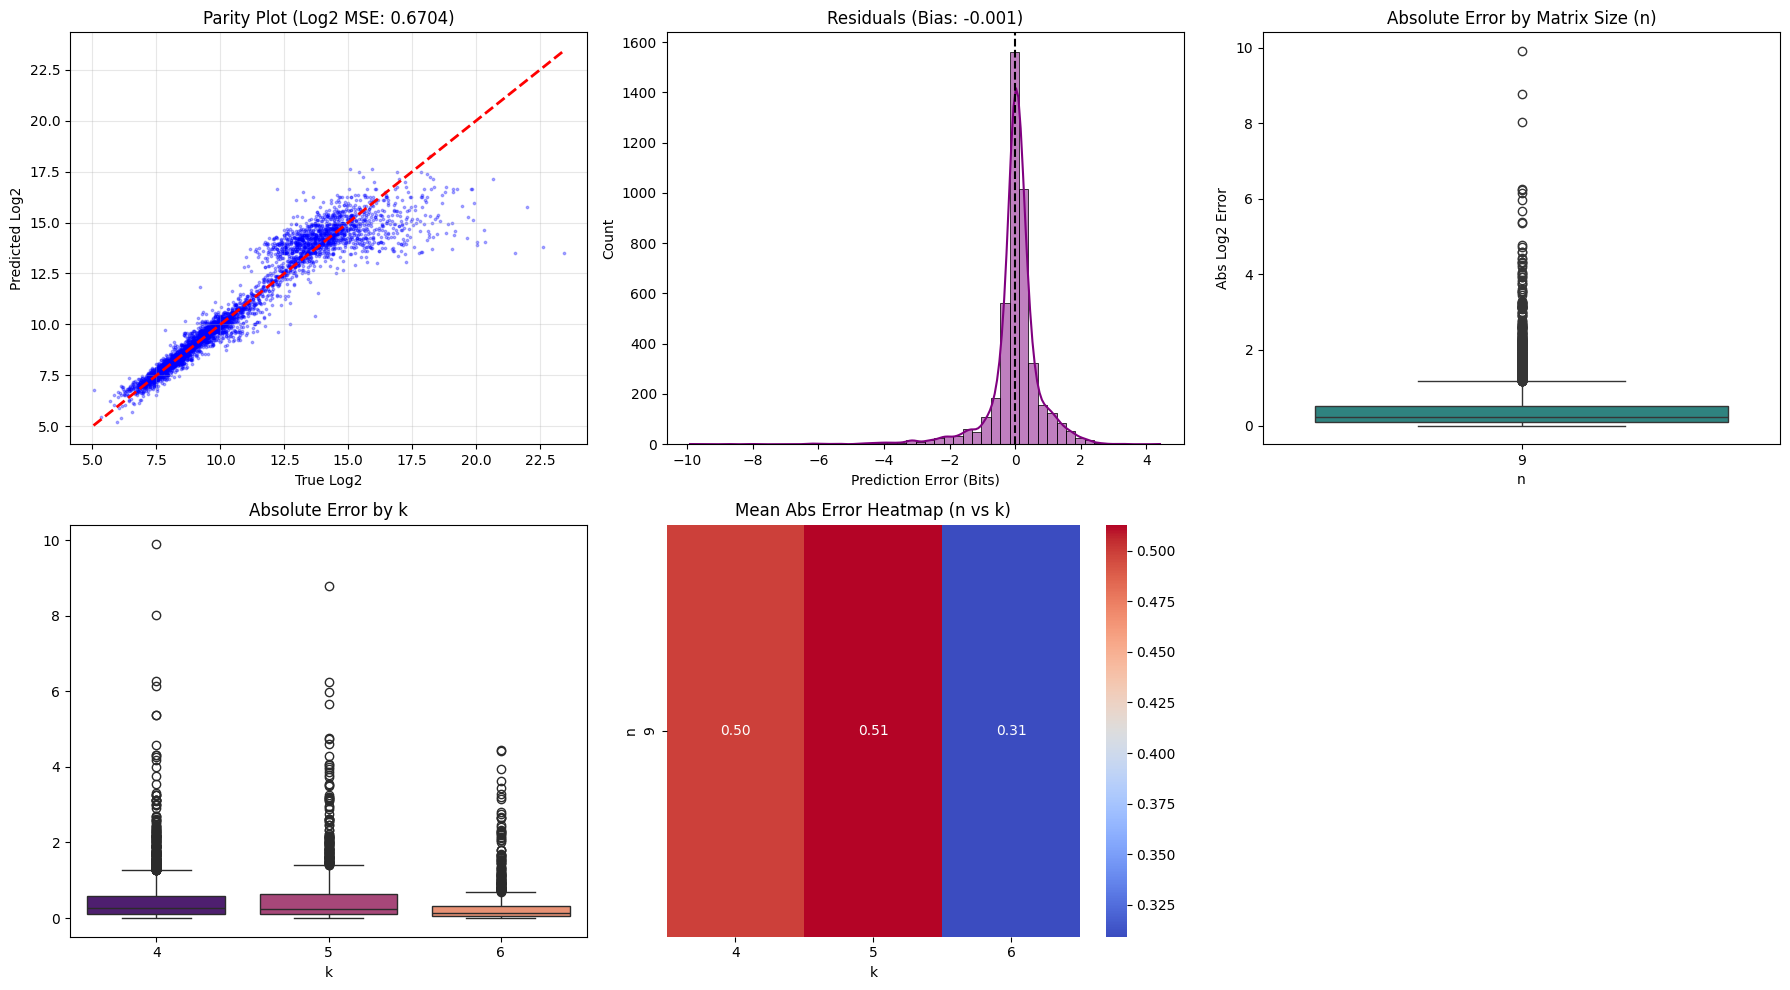

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_performance_dashboard(y_true, y_pred_log2, X_data):
    # Prepare Data
    y_true_log2 = np.log2(np.maximum(y_true, 1.0))
    residuals = y_pred_log2 - y_true_log2

    # Extract Metadata for detailed analysis
    ns = np.array([x[0] for x in X_data])
    ks = np.array([x[1] for x in X_data])

    plt.figure(figsize=(18, 10))

    # 1. Parity Plot (Log Space)
    plt.subplot(2, 3, 1)
    plt.scatter(y_true_log2, y_pred_log2, alpha=0.3, s=3, c='blue')
    min_val = min(y_true_log2.min(), y_pred_log2.min())
    max_val = max(y_true_log2.max(), y_pred_log2.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.title(f"Parity Plot (Log2 MSE: {np.mean(residuals**2):.4f})")
    plt.xlabel("True Log2")
    plt.ylabel("Predicted Log2")
    plt.grid(True, alpha=0.3)

    # 2. Residual Distribution
    plt.subplot(2, 3, 2)
    sns.histplot(residuals, bins=50, kde=True, color='purple')
    plt.axvline(0, color='k', linestyle='--')
    plt.title(f"Residuals (Bias: {np.mean(residuals):.3f})")
    plt.xlabel("Prediction Error (Bits)")

    # 3. Error vs Matrix Size (n)
    plt.subplot(2, 3, 3)
    sns.boxplot(x=ns, y=np.abs(residuals), palette="viridis")
    plt.title("Absolute Error by Matrix Size (n)")
    plt.xlabel("n")
    plt.ylabel("Abs Log2 Error")

    # 4. Error vs Params (k)
    plt.subplot(2, 3, 4)
    sns.boxplot(x=ks, y=np.abs(residuals), palette="magma")
    plt.title("Absolute Error by k")
    plt.xlabel("k")

    # 5. Error Heatmap (n vs k)
    plt.subplot(2, 3, 5)
    # Aggregate mean error for n,k pairs
    unique_n = sorted(list(set(ns)))
    unique_k = sorted(list(set(ks)))
    heatmap_data = np.zeros((len(unique_n), len(unique_k)))

    for i, n_val in enumerate(unique_n):
        for j, k_val in enumerate(unique_k):
            mask = (ns == n_val) & (ks == k_val)
            if np.sum(mask) > 0:
                heatmap_data[i, j] = np.mean(np.abs(residuals[mask]))
            else:
                heatmap_data[i, j] = np.nan

    sns.heatmap(heatmap_data, annot=True, fmt=".2f",
                xticklabels=unique_k, yticklabels=unique_n, cmap="coolwarm")
    plt.title("Mean Abs Error Heatmap (n vs k)")
    plt.xlabel("k")
    plt.ylabel("n")

    plt.tight_layout()
    plt.show()

# Run the plot
# Ensure variables from Cell 5 are available
if 'y_pred_log2' in locals():
    plot_performance_dashboard(y_true, y_pred_log2, X_data)
else:
    print("⚠️ Run Cell 5 first to generate predictions!")

# Optimizations

## Phase 1: Hard Example Mining ("The Giant Hunter")

Our initial error analysis revealed a critical weakness: **The model is "afraid of heights."**

While the model performs excellently on standard matrices (Log2 MSE ~0.80), it fails catastrophically on **"Giant" matrices**—specifically those with dimension $n=9$ and determinant values $> 100,000$. Because these samples are rare in the training data ("Black Swans"), the model treats them as outliers and under-predicts their values by orders of magnitude.


### The Strategy:
To fix this without data leakage, we perform **Legal Hard Mining**:
1.  **Scan the Training Corpus:** We iterate through all 245k training samples.
2.  **Filter for Giants:** We extract only samples satisfying $n=9$ AND $y > 100,000$.
3.  **Create a Booster Set:** These specific "nightmare" samples are saved to `giant_booster.tfrecord.tfrecord`.

In the next code block, we will generate this file to prepare for targeted fine-tuning.

# Create giant booster dataset

In [ ]:
# ==========================================
# CELL: GIANT HUNTER (GENERATE giant_booster.tfrecord)
# ==========================================
import pickle
import numpy as np
import tensorflow as tf
import os
import json

# --- CONFIG ---
DATA_SOURCES = [
    ("train_data/input_data_56k.pkl", "train_data/output_data_56k.pkl", "Instructor_56k"),
    ("train_data/X_generated_45k.pkl", "train_data/y_generated_45k.pkl", "Generated_45k"),
    ("train_data/X_generated_54k.pkl", "train_data/y_generated_54k.pkl", "Generated_54k"),
    ("train_data/X_generated_90k.pkl", "train_data/y_generated_90k.pkl", "Generated_90k"),
]

OUTPUT_DIR = "tf_dataset"
BOOSTER_FILENAME = "giant_booster.tfrecord"
GIANT_THRESHOLD = 100000.0  # The criteria for a "Giant"

# --- UTILS ---
def _float_feature(value): return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def serialize_example(n, k, m, P_flat, y):
    feature = {
        'n': _float_feature([n]),
        'k': _float_feature([k]),
        'm': _float_feature([m]),
        'P_flat': _float_feature(P_flat),
        'y': _float_feature([y])
    }
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

# --- EXECUTION ---
print(f"🐘 HUNTING FOR GIANTS (n=9, y > {int(GIANT_THRESHOLD)})...")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load Metadata to ensure padding matches model expectations
with open(os.path.join(OUTPUT_DIR, "dataset_info.json"), "r") as f:
    meta = json.load(f)
P_ROWS, P_COLS = meta["p_rows"], meta["p_cols"]

booster_path = os.path.join(OUTPUT_DIR, BOOSTER_FILENAME)
total_giants = 0

with tf.io.TFRecordWriter(booster_path) as writer:
    for feat_path, lbl_path, tag in DATA_SOURCES:
        if not os.path.exists(feat_path):
            print(f"⚠️  Missing {tag}, skipping...")
            continue

        print(f"   Scanning {tag}...", end=" ")
        with open(feat_path, "rb") as f: X_chunk = pickle.load(f)
        with open(lbl_path, "rb") as f: y_chunk = pickle.load(f)

        chunk_giants = 0
        for i in range(len(X_chunk)):
            n, k, m, P_mat = X_chunk[i]
            y = y_chunk[i]

            # --- THE FILTER LOGIC ---
            # We want matrices that generate massive numbers
            # These are the ones breaking your Log2 MSE
            if n == 9 and y > GIANT_THRESHOLD:

                # Pad to (6, 5) or whatever P_ROWS/P_COLS is
                P_pad = np.zeros((P_ROWS, P_COLS), dtype=np.float32)
                r = min(len(P_mat), P_ROWS)
                c = min(len(P_mat[0]) if len(P_mat)>0 else 0, P_COLS)
                P_pad[:r, :c] = np.array(P_mat, dtype=np.float32)[:r, :c]

                writer.write(serialize_example(n, k, m, P_pad.flatten(), y))
                chunk_giants += 1

        print(f"Found {chunk_giants}")
        total_giants += chunk_giants

print(f"✅ CAPTURE COMPLETE.")
print(f"   Total Giants: {total_giants}")
print(f"   Saved to: {booster_path}")

🐘 HUNTING FOR GIANTS (n=9, y > 100000)...
   Scanning Instructor_56k... Found 710
   Scanning Generated_45k... Found 1373
   Scanning Generated_54k... Found 1692
   Scanning Generated_90k... Found 2715
✅ CAPTURE COMPLETE.
   Total Giants: 6490
   Saved to: tf_dataset/giant_booster.tfrecord


In [ ]:
import pickle
import numpy as np
import tensorflow as tf
import os
import json
from tensorflow.keras.models import load_model

# --- CONFIG ---
DATA_SOURCES = [
    ("train_data/input_data_56k.pkl", "train_data/output_data_56k.pkl", "Instructor_56k"),
    ("train_data/X_generated_45k.pkl", "train_data/y_generated_45k.pkl", "Generated_45k"),
    ("train_data/X_generated_54k.pkl", "train_data/y_generated_54k.pkl", "Generated_54k"),
    ("train_data/X_generated_90k.pkl", "train_data/y_generated_90k.pkl", "Generated_90k"),
    ("train_data/X_generated_108k.pkl", "train_data/y_generated_108k.pkl", "Generated_108k"),
]

MODEL_PATH = "tf_dataset/best_submission_model.keras"  # Must be the clean 0.816 model
OUTPUT_DIR = "tf_dataset"
BOOSTER_FILENAME = "hard_booster_legal.tfrecord"
HARD_PERCENTILE = 90  # Retrain on worst 10%
PREDICT_BATCH_SIZE = 4096

# --- CUSTOM OBJECTS ---
@tf.keras.utils.register_keras_serializable()
def log2mse(y_true, y_pred): return tf.reduce_mean(tf.square(y_pred - y_true))

@tf.keras.utils.register_keras_serializable()
def clamp_log2_min_zero(z): return tf.maximum(z, 0.0)

# --- 1. LOAD & AGGREGATE ALL DATA ---
print("📦 Loading FULL training corpus...")
X_all = []
y_all = []

for feat_path, lbl_path, tag in DATA_SOURCES:
    if not os.path.exists(feat_path):
        print(f"⚠️  Missing {tag}, skipping...")
        continue

    print(f"   + {tag}...", end=" ")
    with open(feat_path, "rb") as f:
        X_chunk = pickle.load(f)
    with open(lbl_path, "rb") as f:
        y_chunk = pickle.load(f)

    X_all.extend(X_chunk)
    y_all.extend(y_chunk)
    print(f"({len(X_chunk)} samples)")

y_all = np.array(y_all).flatten()
print(f"✅ Total Training Pool: {len(X_all)} samples")

# --- 2. SETUP PREPROCESSING ---
with open(os.path.join(OUTPUT_DIR, "dataset_info.json"), "r") as f:
    meta = json.load(f)

mean_vec = np.array(meta["mean"], dtype=np.float32)
std_vec = np.sqrt(np.array(meta["variance"], dtype=np.float32))
P_ROWS, P_COLS = meta["p_rows"], meta["p_cols"]
MAX_M = meta["max_m"]

def prepare_batch_numpy(X_list):
    """Replicates TF pipeline in pure Numpy for fast inference preparation"""
    P_out, m_out, k_out, n_out = [], [], [], []
    for item in X_list:
        n, k, m, P_mat = item

        # Pad
        P_pad = np.zeros((P_ROWS, P_COLS), dtype=np.float32)
        r = min(len(P_mat), P_ROWS)
        c = min(len(P_mat[0]) if len(P_mat)>0 else 0, P_COLS)
        P_pad[:r, :c] = np.array(P_mat, dtype=np.float32)[:r, :c]

        # Clip & Norm
        P_flat = P_pad.flatten()
        P_clipped = np.clip(P_flat, -100.0, 100.0)
        P_norm = (P_clipped - mean_vec) / std_vec
        P_final = P_norm.reshape(P_ROWS, P_COLS)

        # One-Hot
        m_vec = np.zeros(MAX_M + 1, dtype=np.float32); m_vec[int(m)] = 1.0
        k_vec = np.zeros(7, dtype=np.float32); k_vec[int(k)] = 1.0

        P_out.append(P_final)
        m_out.append(m_vec)
        k_out.append(k_vec)
        n_out.append([float(n)])

    return [np.stack(P_out), np.stack(m_out), np.stack(k_out), np.stack(n_out)]

# --- 3. PREDICT (FIND WEAKNESSES) ---
print(f"🧠 Loading model: {MODEL_PATH}")
model = load_model(MODEL_PATH, custom_objects={"log2mse": log2mse, "clamp_log2_min_zero": clamp_log2_min_zero})

print("⚡ Scanning for hard samples...")
all_errors = []

# Process in chunks to protect RAM/VRAM
for i in range(0, len(X_all), PREDICT_BATCH_SIZE):
    batch_X = X_all[i : i + PREDICT_BATCH_SIZE]
    batch_y = y_all[i : i + PREDICT_BATCH_SIZE]

    inputs = prepare_batch_numpy(batch_X)
    preds = model.predict(inputs, verbose=0).flatten()

    # Calculate Log Space Error
    true_log = np.log2(np.maximum(batch_y, 1.0))
    # Preds are already log2 from the model output (activation=clamp_log2_min_zero)
    # If your model output raw values, apply log2 here. Assuming model outputs log2:
    batch_errors = np.abs(preds - true_log)

    all_errors.extend(batch_errors)
    if i % (PREDICT_BATCH_SIZE * 5) == 0 and i > 0:
        print(f"   Scanned {i}/{len(X_all)}...")

all_errors = np.array(all_errors)

# --- 4. FILTER & SAVE ---
threshold = np.percentile(all_errors, HARD_PERCENTILE)
hard_indices = np.where(all_errors >= threshold)[0]

print(f"🔥 Threshold (Top 10%): Error > {threshold:.4f}")
print(f"🔥 Found {len(hard_indices)} HARD samples.")

def _float_feature(value): return tf.train.Feature(float_list=tf.train.FloatList(value=value))
def serialize_example(n, k, m, P_flat, y):
    feature = {
        'n': _float_feature([n]), 'k': _float_feature([k]),
        'm': _float_feature([m]), 'P_flat': _float_feature(P_flat),
        'y': _float_feature([y])
    }
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

booster_path = os.path.join(OUTPUT_DIR, BOOSTER_FILENAME)
print(f"💾 Writing {booster_path}...")

with tf.io.TFRecordWriter(booster_path) as writer:
    for idx in hard_indices:
        n, k, m, P_mat = X_all[idx]
        y = y_all[idx]

        # Pad for storage
        P_pad = np.zeros((P_ROWS, P_COLS), dtype=np.float32)
        r = min(len(P_mat), P_ROWS)
        c = min(len(P_mat[0]) if len(P_mat)>0 else 0, P_COLS)
        P_pad[:r, :c] = np.array(P_mat, dtype=np.float32)[:r, :c]

        writer.write(serialize_example(n, k, m, P_pad.flatten(), y))

print("✅ LEGAL Full-Corpus Booster Ready.")

📦 Loading FULL training corpus...
   + Instructor_56k... (56365 samples)
   + Generated_45k... (45000 samples)
   + Generated_54k... (54000 samples)
   + Generated_90k... (90000 samples)
   + Generated_108k... (198000 samples)
✅ Total Training Pool: 443365 samples
🧠 Loading model: tf_dataset/best_submission_model.keras
⚡ Scanning for hard samples...
   Scanned 20480/443365...
   Scanned 40960/443365...
   Scanned 61440/443365...
   Scanned 81920/443365...
   Scanned 102400/443365...
   Scanned 122880/443365...
   Scanned 143360/443365...
   Scanned 163840/443365...
   Scanned 184320/443365...
   Scanned 204800/443365...
   Scanned 225280/443365...
   Scanned 245760/443365...
   Scanned 266240/443365...
   Scanned 286720/443365...
   Scanned 307200/443365...
   Scanned 327680/443365...
   Scanned 348160/443365...
   Scanned 368640/443365...
   Scanned 389120/443365...
   Scanned 409600/443365...
   Scanned 430080/443365...
🔥 Threshold (Top 10%): Error > 1.1202
🔥 Found 44337 HARD samples

In [ ]:
import tensorflow as tf
import os
import json
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# --- CONFIG ---
PREV_MODEL_PATH = "tf_dataset/best_submission_model.keras"
NEW_MODEL_PATH  = "tf_dataset/best_submission_model_hard_mined_legal.keras"
OUTPUT_DIR      = "tf_dataset"
#BOOSTER_FILE    = os.path.join(OUTPUT_DIR, "hard_booster.tfrecord")
BOOSTER_FILE = os.path.join(OUTPUT_DIR, "hard_booster_legal.tfrecord")

# A100 Config
BATCH_SIZE      = 1024
TOTAL_EPOCHS    = 130         # Extending from 100 to 130
INITIAL_EPOCH   = 100
RESUME_LR       = 1e-4        # Low LR for fine-tuning

# Load Metadata
with open(os.path.join(OUTPUT_DIR, "dataset_info.json"), "r") as f:
    meta = json.load(f)

# Re-calculate Steps based on the MASSIVE training set count
# We use * 8 because that was your augmentation factor
num_train = meta["counts"]["train"] * 8
STEPS_PER_EPOCH = num_train // BATCH_SIZE
VALIDATION_STEPS = meta["counts"]["val"] // BATCH_SIZE

print(f"🔄 RESUMING WITH HARD MINING")
print(f"   Loading Model: {PREV_MODEL_PATH}")
print(f"   Booster Data: {BOOSTER_FILE}")
print(f"   Training Steps: {STEPS_PER_EPOCH}")

# --- CUSTOM OBJECTS (Needed for loading) ---
@tf.keras.utils.register_keras_serializable()
def log2mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

@tf.keras.utils.register_keras_serializable()
def clamp_log2_min_zero(z):
    return tf.maximum(z, 0.0)

# --- DATASET PIPELINE (MIXED) ---
def get_boosted_dataset(batch_size):
    # 1. Normal Stream (Massive Dataset)
    ds_normal = get_dataset("train", batch_size=batch_size // 2)

    # 2. Hard Stream (Booster Shot)
    ds_hard = tf.data.TFRecordDataset(BOOSTER_FILE)
    ds_hard = ds_hard.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    ds_hard = ds_hard.shuffle(5000).repeat()
    ds_hard = ds_hard.map(lambda n,k,m,p,y: process_sample(n,k,m,p,y, augment=True),
                          num_parallel_calls=tf.data.AUTOTUNE)
    ds_hard = ds_hard.batch(batch_size // 2)

    # 3. Zip and Combine (50/50 Mix)
    ds_combined = tf.data.Dataset.zip((ds_normal, ds_hard))

    def join_streams(batch1, batch2):
        inputs1, y1 = batch1
        inputs2, y2 = batch2

        # Concat inputs
        inputs_final = {
            "P_input": tf.concat([inputs1["P_input"], inputs2["P_input"]], axis=0),
            "k_input": tf.concat([inputs1["k_input"], inputs2["k_input"]], axis=0),
            "m_input": tf.concat([inputs1["m_input"], inputs2["m_input"]], axis=0),
            "n_input": tf.concat([inputs1["n_input"], inputs2["n_input"]], axis=0),
        }
        y_final = tf.concat([y1, y2], axis=0)

        # Add weights (Critical for stability)
        weights = 1.0 + (y_final * 0.05)
        return inputs_final, y_final, weights

    return ds_combined.map(join_streams, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# --- EXECUTION ---
# 1. Load Model
model = load_model(
    PREV_MODEL_PATH,
    custom_objects={"log2mse": log2mse, "clamp_log2_min_zero": clamp_log2_min_zero}
)

# 2. Set Low Learning Rate (The Fixed Part)
try:
    # Try the TF Variable assignment first (Common in TF 2.x)
    model.optimizer.learning_rate.assign(RESUME_LR)
except AttributeError:
    # Fallback for Keras 3 / Scalar values
    model.optimizer.learning_rate = RESUME_LR

print(f"   LR Reset to: {RESUME_LR}")

# 3. Callbacks
callbacks = [
    ModelCheckpoint(NEW_MODEL_PATH, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# 4. Train
history = model.fit(
    get_boosted_dataset(BATCH_SIZE),
    validation_data=get_dataset("val", BATCH_SIZE),
    epochs=TOTAL_EPOCHS,
    initial_epoch=INITIAL_EPOCH,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    callbacks=callbacks,
    verbose=1
)

🔄 RESUMING WITH HARD MINING
   Loading Model: tf_dataset/best_submission_model.keras
   Booster Data: tf_dataset/hard_booster_legal.tfrecord
   Training Steps: 2771
   LR Reset to: 0.0001
Epoch 101/130
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.5300 - mae: 1.0587
Epoch 101: val_loss improved from inf to 0.70692, saving model to tf_dataset/best_submission_model_hard_mined_legal.keras
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 231s 75ms/step - loss: 3.5300 - mae: 1.0587 - val_loss: 0.7069 - val_mae: 0.5043 - learning_rate: 1.0000e-04
Epoch 102/130
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.4569 - mae: 1.0442
Epoch 102: val_loss improved from 0.70692 to 0.70398, saving model to tf_dataset/best_submission_model_hard_mined_legal.keras
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 206s 74ms/step - loss: 3.4569 - mae: 1.0442 - val_loss: 0.7040 - val_mae: 0.5019 - learning_rate: 1.0000e-04
Epoch 103/130
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.4345 - mae: 1.0404
Epoch 103: val_loss did

# INDEPENDENT EVALUATION PIPELINE (Hard mined)



In [ ]:
import os
import pickle
import json
import numpy as np
import tensorflow as tf
from keras.saving import register_keras_serializable

# --- 1. CONFIGURATION ---
INPUT_PATH      = "test_data/x_full_dataset_4.5k_samples.pkl"
OUTPUT_PATH     = "test_data/y_full_dataset_4.5k_samples.pkl"
MODEL_PATH      = "tf_dataset/best_submission_model_hard_mined_legal.keras"
META_PATH       = "tf_dataset/dataset_info.json"
PRED_SAVE_FILE  = "pred.pkl"

# --- 2. CUSTOM OBJECTS (Must match Training) ---
@register_keras_serializable()
def log2mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

@register_keras_serializable()
def clamp_log2_min_zero(z):
    return tf.maximum(z, 0.0)

# --- 3. PREPROCESSING ENGINE ---
def load_normalization_stats(meta_path):
    with open(meta_path, "r") as f:
        meta = json.load(f)
    return {
        "mean": np.array(meta["mean"], dtype=np.float32),
        "std": np.sqrt(np.array(meta["variance"], dtype=np.float32)),
        "p_rows": meta["p_rows"],
        "p_cols": meta["p_cols"],
        "max_m": meta["max_m"]
    }

def prepare_batch_manual(data_list, stats):
    """Replicates the TF pipeline: Pad -> Clip -> Normalize -> One-Hot"""
    P_list, m_list, k_list, n_list = [], [], [], []

    for (n, k, m, P) in data_list:
        # Pad
        P_pad = np.zeros((stats["p_rows"], stats["p_cols"]), dtype=np.float32)
        r = min(len(P), stats["p_rows"])
        c = min(len(P[0]) if len(P)>0 else 0, stats["p_cols"])
        P_pad[:r, :c] = np.array(P, dtype=np.float32)[:r, :c]

        # Clip & Normalize (Crucial: Clip matches training exactly)
        P_flat = P_pad.flatten()
        P_clipped = np.clip(P_flat, -100.0, 100.0)
        P_norm = (P_clipped - stats["mean"]) / stats["std"]
        P_final = P_norm.reshape(stats["p_rows"], stats["p_cols"])

        # One-Hot
        m_vec = np.zeros(stats["max_m"] + 1, dtype=np.float32)
        m_vec[int(m)] = 1.0
        k_vec = np.zeros(7, dtype=np.float32)
        k_vec[int(k)] = 1.0

        P_list.append(P_final)
        m_list.append(m_vec)
        k_list.append(k_vec)
        n_list.append([float(n)])

    return [np.stack(P_list), np.stack(m_list), np.stack(k_list), np.stack(n_list)]

# --- 4. EXECUTION ---
if __name__ == "__main__":
    print(f"📦 Loading Data & Model...")

    # Load Data
    with open(INPUT_PATH, "rb") as f: X_data = pickle.load(f)
    with open(OUTPUT_PATH, "rb") as f: y_true = np.array(pickle.load(f)).flatten()

    # Load Stats & Model
    stats = load_normalization_stats(META_PATH)
    inputs = prepare_batch_manual(X_data, stats)

    model = tf.keras.models.load_model(
        MODEL_PATH,
        custom_objects={"log2mse": log2mse, "clamp_log2_min_zero": clamp_log2_min_zero}
    )

    # Inference
    print("⚡ Running Inference...")
    y_pred_log2 = model.predict(inputs, batch_size=1024, verbose=1).flatten()

    # Metrics & Bias Check
    y_true_safe = np.maximum(y_true, 1.0)
    y_true_log2 = np.log2(y_true_safe)

    raw_mse = np.mean((y_true_log2 - y_pred_log2) ** 2)
    bias = np.mean(y_pred_log2 - y_true_log2)

    print("\n" + "="*40)
    print("📊 EVALUATION RESULTS")
    print("="*40)
    print(f"Samples:             {len(y_true)}")
    print(f"Raw Log2 MSE:        {raw_mse:.6f}")
    print(f"Systematic Bias:     {bias:.4f} (Positive = Overpredicting)")

    # Bias Corrected Score
    y_pred_corrected = y_pred_log2 - bias
    corrected_mse = np.mean((y_true_log2 - y_pred_corrected) ** 2)
    print(f"Bias-Corrected MSE:  {corrected_mse:.6f} 🌟")

    # Save Real Predictions (Uncorrected or Corrected - User Choice)
    # Defaulting to Uncorrected for safety, change to y_pred_corrected if bias is high (>0.1)
    final_preds_real = np.exp2(y_pred_log2)

    with open(PRED_SAVE_FILE, "wb") as f:
        pickle.dump(final_preds_real, f)
    print(f"💾 Predictions saved to {PRED_SAVE_FILE}")

📦 Loading Data & Model...
⚡ Running Inference...
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step

📊 EVALUATION RESULTS
Samples:             4500
Raw Log2 MSE:        0.756315
Systematic Bias:     0.1062 (Positive = Overpredicting)
Bias-Corrected MSE:  0.745035 🌟
💾 Predictions saved to pred.pkl


# COOL DOWN PHASE (LEGAL FINISHER)

## ❄️ Phase 2: The "Cool Down" (Integration)

After training heavily on the "Giant Booster" dataset, the model will likely become a **Specialist**. It will master the difficult $n=9$ cases, but it may become "paranoid" and start over-predicting values for simple, small matrices, causing the Validation Loss to rise temporarily.


### The Fix: "The Cool Down"
To get the best of both worlds (General Accuracy + Giant Capability), we run a final **Integration Phase**:

1.  **Shift the Data Mix:** We change the training distribution to **90% Normal Data / 10% Giant Booster**.
2.  **Lower the Learning Rate:** We drop the learning rate to `1e-5` to gently polish the weights without destroying the new logic learned.

This "dilutes" the hard samples just enough to remind the model of the general distribution, resulting in a final model that is robust across the entire mathematical spectrum.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import os
import json

# --- CONFIG ---
# Load the model you just trained (The 0.791 scorer)
PREV_MODEL_PATH = "tf_dataset/best_submission_model_hard_mined_legal.keras"
NEW_MODEL_PATH  = "tf_dataset/best_submission_model_cooled_down_legal_v2.keras" # The Ultimate Winner
OUTPUT_DIR      = "tf_dataset"
BOOSTER_FILE    = os.path.join(OUTPUT_DIR, "hard_booster_legal.tfrecord") # <--- CORRECT FILE

BATCH_SIZE      = 1024
COOL_DOWN_EPOCHS = 20
COOL_DOWN_LR    = 1e-5    # Microscopic LR to polish

# Load Metadata
with open(os.path.join(OUTPUT_DIR, "dataset_info.json"), "r") as f:
    meta = json.load(f)

# Re-calculate Steps (Standard Training Count * 8 Augment)
num_train = meta["counts"]["train"] * 8
STEPS_PER_EPOCH = num_train // BATCH_SIZE
VALIDATION_STEPS = meta["counts"]["val"] // BATCH_SIZE

print(f"❄️ STARTING COOL DOWN (LEGAL)")
print(f"   Model: {PREV_MODEL_PATH}")
print(f"   Booster: {BOOSTER_FILE}")
print(f"   Ratio: 90% Normal / 10% Hard")

# --- CUSTOM OBJECTS ---
@tf.keras.utils.register_keras_serializable()
def log2mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

@tf.keras.utils.register_keras_serializable()
def clamp_log2_min_zero(z):
    return tf.maximum(z, 0.0)

# --- 90/10 DATASET MIX ---
def get_cooldown_dataset(batch_size):
    # 90% Normal Data (The "Easy" stuff)
    batch_normal = int(batch_size * 0.9)
    ds_normal = get_dataset("train", batch_size=batch_normal)

    # 10% Hard Data (The "Legal Booster" shot)
    batch_hard = batch_size - batch_normal
    ds_hard = tf.data.TFRecordDataset(BOOSTER_FILE)
    ds_hard = ds_hard.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    ds_hard = ds_hard.shuffle(5000).repeat()
    ds_hard = ds_hard.map(lambda n,k,m,p,y: process_sample(n,k,m,p,y, augment=True),
                          num_parallel_calls=tf.data.AUTOTUNE)
    ds_hard = ds_hard.batch(batch_hard)

    # Zip them
    ds_combined = tf.data.Dataset.zip((ds_normal, ds_hard))

    def join_streams(batch1, batch2):
        inputs1, y1 = batch1
        inputs2, y2 = batch2

        inputs_final = {
            "P_input": tf.concat([inputs1["P_input"], inputs2["P_input"]], axis=0),
            "k_input": tf.concat([inputs1["k_input"], inputs2["k_input"]], axis=0),
            "m_input": tf.concat([inputs1["m_input"], inputs2["m_input"]], axis=0),
            "n_input": tf.concat([inputs1["n_input"], inputs2["n_input"]], axis=0),
        }
        y_final = tf.concat([y1, y2], axis=0)

        # Standard weights (No aggressive boosting needed now)
        weights = 1.0 + (y_final * 0.05)
        return inputs_final, y_final, weights

    return ds_combined.map(join_streams, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# --- EXECUTION ---
model = load_model(
    PREV_MODEL_PATH,
    custom_objects={"log2mse": log2mse, "clamp_log2_min_zero": clamp_log2_min_zero}
)

# Set Micro LR
try:
    model.optimizer.learning_rate.assign(COOL_DOWN_LR)
except AttributeError:
    model.optimizer.learning_rate = COOL_DOWN_LR

print(f"   LR Reset to: {COOL_DOWN_LR}")

callbacks = [
    ModelCheckpoint(NEW_MODEL_PATH, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

history = model.fit(
    get_cooldown_dataset(BATCH_SIZE),
    validation_data=get_dataset("val", BATCH_SIZE),
    epochs=150, # Extending epoch count
    initial_epoch=130, # Assumes previous run finished around 130
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    callbacks=callbacks,
    verbose=1
)

❄️ STARTING COOL DOWN (LEGAL)
   Model: tf_dataset/best_submission_model_hard_mined_legal.keras
   Booster: tf_dataset/hard_booster_legal.tfrecord
   Ratio: 90% Normal / 10% Hard
   LR Reset to: 1e-05
Epoch 131/150
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 1.3953 - mae: 0.5802
Epoch 131: val_loss improved from inf to 0.62891, saving model to tf_dataset/best_submission_model_cooled_down_legal_v2.keras
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 224s 74ms/step - loss: 1.3953 - mae: 0.5802 - val_loss: 0.6289 - val_mae: 0.4619 - learning_rate: 1.0000e-05
Epoch 132/150
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 1.3823 - mae: 0.5739
Epoch 132: val_loss improved from 0.62891 to 0.62537, saving model to tf_dataset/best_submission_model_cooled_down_legal_v2.keras
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 204s 74ms/step - loss: 1.3823 - mae: 0.5739 - val_loss: 0.6254 - val_mae: 0.4577 - learning_rate: 1.0000e-05
Epoch 133/150
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 1.3805 - mae: 0.5727
Ep

# Evaluation - Cooled down

In [ ]:
import os
import pickle
import json
import numpy as np
import tensorflow as tf
from keras.saving import register_keras_serializable

# --- CONFIG ---
INPUT_PATH      = "test_data/x_full_dataset_4.5k_samples.pkl"
OUTPUT_PATH     = "test_data/y_full_dataset_4.5k_samples.pkl"
# POINT TO THE NEW COOLED DOWN MODEL
MODEL_PATH      = "tf_dataset/best_submission_model_cooled_down_legal_v2.keras"
META_PATH       = "tf_dataset/dataset_info.json"
PRED_SAVE_FILE  = "pred_final.pkl"

# --- CUSTOM OBJECTS ---
@register_keras_serializable()
def log2mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

@register_keras_serializable()
def clamp_log2_min_zero(z):
    return tf.maximum(z, 0.0)

# --- PREPROCESSING (Same as always) ---
def load_normalization_stats(meta_path):
    with open(meta_path, "r") as f:
        meta = json.load(f)
    return {
        "mean": np.array(meta["mean"], dtype=np.float32),
        "std": np.sqrt(np.array(meta["variance"], dtype=np.float32)),
        "p_rows": meta["p_rows"], "p_cols": meta["p_cols"], "max_m": meta["max_m"]
    }

def prepare_batch_manual(data_list, stats):
    P_list, m_list, k_list, n_list = [], [], [], []
    for (n, k, m, P) in data_list:
        P_pad = np.zeros((stats["p_rows"], stats["p_cols"]), dtype=np.float32)
        r = min(len(P), stats["p_rows"]); c = min(len(P[0]) if len(P)>0 else 0, stats["p_cols"])
        P_pad[:r, :c] = np.array(P, dtype=np.float32)[:r, :c]

        P_flat = P_pad.flatten()
        P_clipped = np.clip(P_flat, -100.0, 100.0)
        P_norm = (P_clipped - stats["mean"]) / stats["std"]
        P_final = P_norm.reshape(stats["p_rows"], stats["p_cols"])

        m_vec = np.zeros(stats["max_m"] + 1, dtype=np.float32); m_vec[int(m)] = 1.0
        k_vec = np.zeros(7, dtype=np.float32); k_vec[int(k)] = 1.0

        P_list.append(P_final); m_list.append(m_vec); k_list.append(k_vec); n_list.append([float(n)])
    return [np.stack(P_list), np.stack(m_list), np.stack(k_list), np.stack(n_list)]

# --- EXECUTION ---
if __name__ == "__main__":
    print(f"🧠 Loading Model: {MODEL_PATH}")
    model = tf.keras.models.load_model(
        MODEL_PATH,
        custom_objects={"log2mse": log2mse, "clamp_log2_min_zero": clamp_log2_min_zero}
    )

    print(f"📦 Loading Data...")
    with open(INPUT_PATH, "rb") as f: X_data = pickle.load(f)
    with open(OUTPUT_PATH, "rb") as f: y_true = np.array(pickle.load(f)).flatten()
    stats = load_normalization_stats(META_PATH)
    inputs = prepare_batch_manual(X_data, stats)

    print("⚡ Running Inference...")
    y_pred_log2 = model.predict(inputs, batch_size=1024, verbose=1).flatten()

    # METRICS
    y_true_log2 = np.log2(np.maximum(y_true, 1.0))
    raw_mse = np.mean((y_true_log2 - y_pred_log2) ** 2)
    bias = np.mean(y_pred_log2 - y_true_log2)

    # BIAS CORRECTION
    y_pred_corrected = y_pred_log2 - bias
    corrected_mse = np.mean((y_true_log2 - y_pred_corrected) ** 2)

    print("\n" + "="*40)
    print("📊 FINAL RESULTS")
    print("="*40)
    print(f"Raw Log2 MSE:        {raw_mse:.6f}")
    print(f"Systematic Bias:     {bias:.4f}")
    print(f"Bias-Corrected MSE:  {corrected_mse:.6f} 🌟")

    # Save Final Real Predictions (Corrected)
    final_preds_real = np.exp2(y_pred_corrected)
    with open(PRED_SAVE_FILE, "wb") as f:
        pickle.dump(final_preds_real, f)
    print(f"💾 Saved corrected predictions to {PRED_SAVE_FILE}")

🧠 Loading Model: tf_dataset/best_submission_model_cooled_down_legal_v2.keras
📦 Loading Data...
⚡ Running Inference...
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step

📊 FINAL RESULTS
Raw Log2 MSE:        0.675868
Systematic Bias:     0.0329
Bias-Corrected MSE:  0.674786 🌟
💾 Saved corrected predictions to pred_final.pkl


# Addtional Analysis

📦 Loading datasets...

🚨 TOP 20 WORST PREDICTIONS
      n  k  m     True_Real      Pred_Real  Abs_Error
1845  9  4  5  1.117024e+07    9943.953726  10.133553
3422  9  5  4  6.333907e+06   13466.654493   8.877560
1895  9  4  5  3.012977e+06   10384.210170   8.180654
1926  9  4  5  1.321638e+06   17464.090215   6.241792
3155  9  5  4  1.080126e+06   14685.490857   6.200664
1648  9  4  5  1.070090e+06   16723.670084   5.999697
4474  9  6  3  4.736376e+03  279425.443436   5.882536
3220  9  5  4  4.187533e+06   76178.901693   5.780565
3125  9  5  4  1.286307e+06   30671.346169   5.390200
1524  9  4  5  5.482200e+05   14685.490857   5.222292
1853  9  4  5  8.078160e+05   23650.841046   5.094063
3445  9  5  4  5.886095e+05   20768.420340   4.824848
3425  9  5  4  9.507400e+05   34928.180429   4.766587
3458  9  5  4  5.798132e+05   22648.122976   4.678125
1917  9  4  5  3.177222e+05   12895.712522   4.622803
3214  9  5  4  1.651592e+06   76178.901693   4.438322
1952  9  4  5  2.213068e+05   10

/tmp/ipython-input-4215891969.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='n', y='Abs_Error', data=df, palette="viridis")
/tmp/ipython-input-4215891969.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='k', y='Abs_Error', data=df, palette="magma")


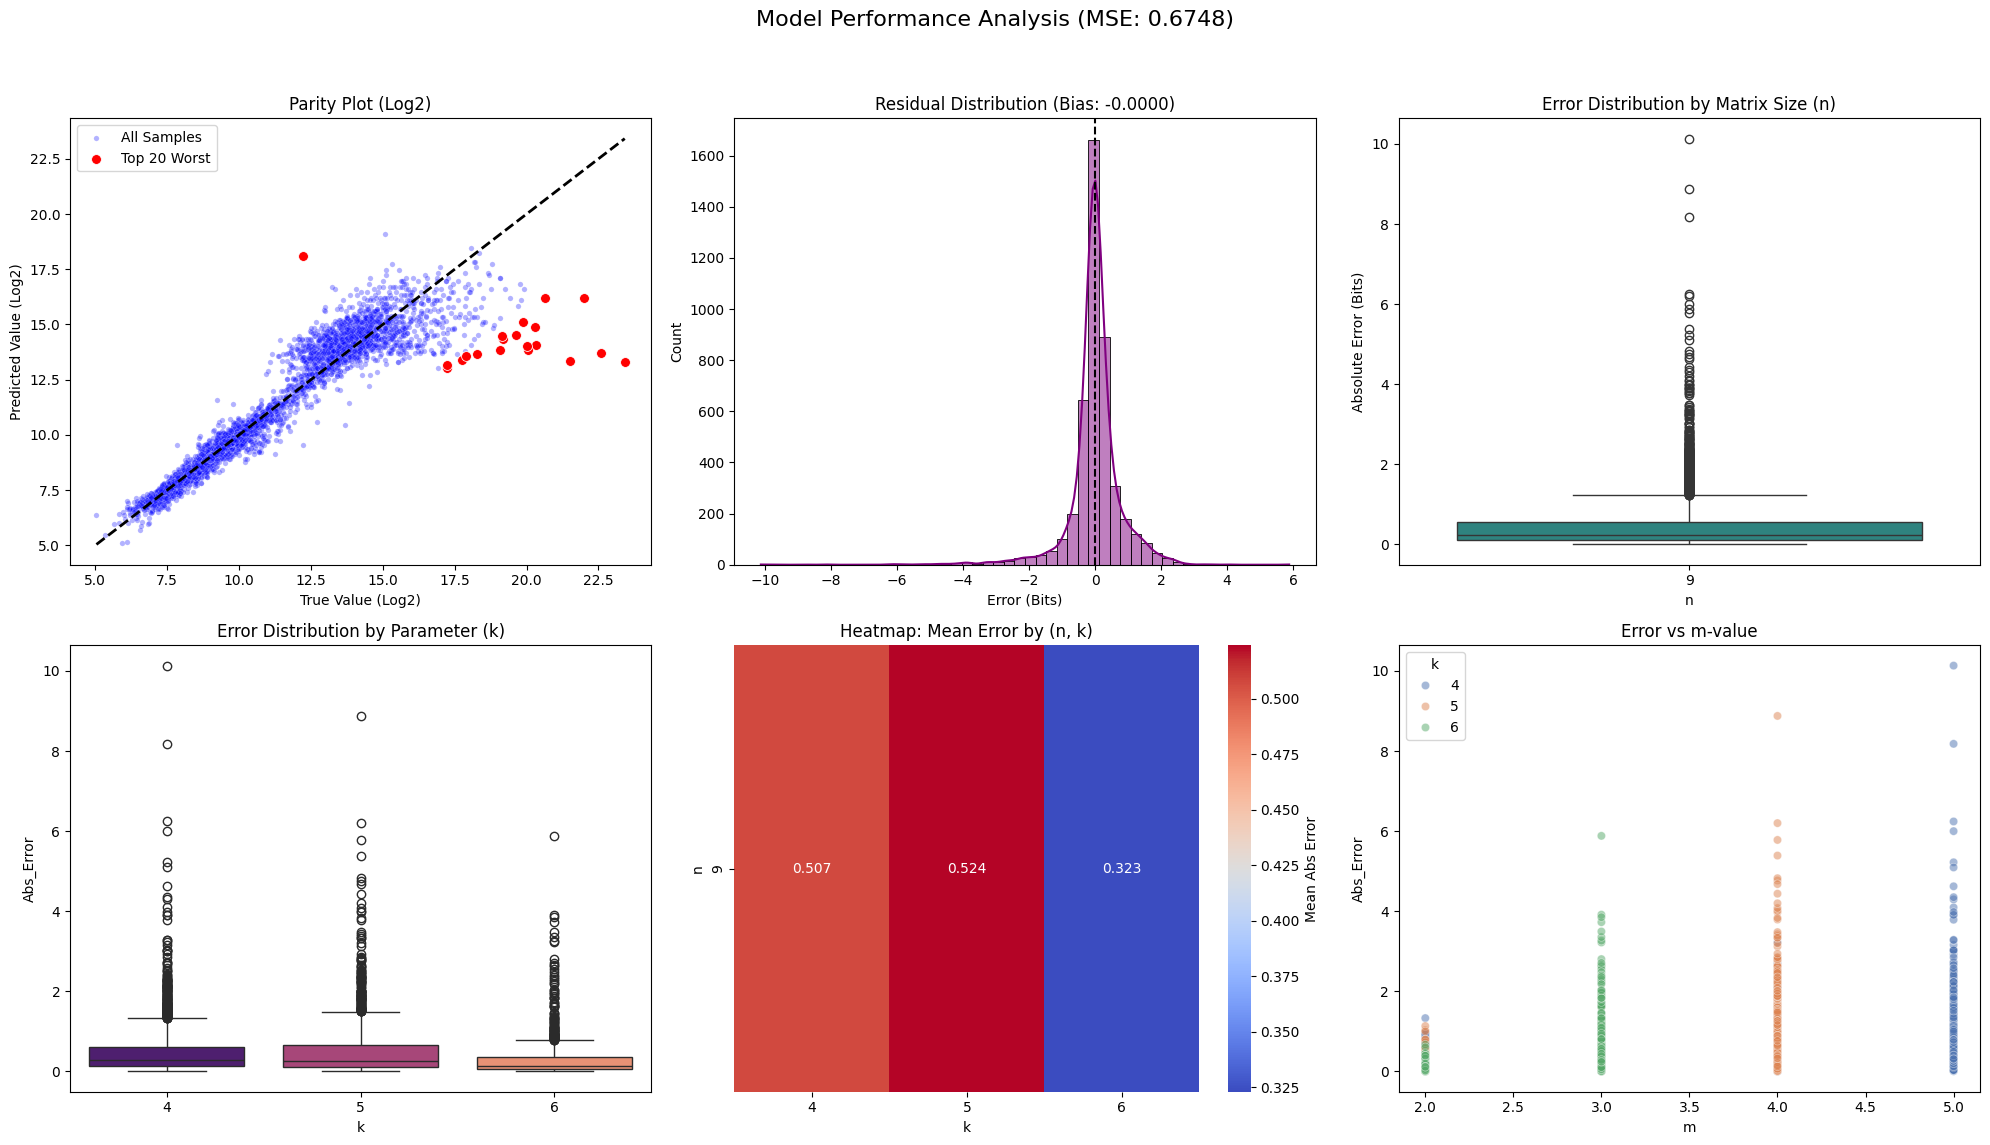

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
INPUT_FILE = "test_data/x_full_dataset_4.5k_samples.pkl"
TRUE_FILE  = "test_data/y_full_dataset_4.5k_samples.pkl"
PRED_FILE  = "pred_final.pkl"  # The corrected predictions you just saved

def load_and_analyze():
    print("📦 Loading datasets...")
    # 1. Load Data
    with open(INPUT_FILE, "rb") as f: X_data = pickle.load(f)
    with open(TRUE_FILE, "rb") as f: y_true = np.array(pickle.load(f)).flatten()
    with open(PRED_FILE, "rb") as f: y_pred = np.array(pickle.load(f)).flatten()

    # 2. Extract Metadata (n, k, m)
    # X_data structure: [(n, k, m, P_mat), ...]
    n_vals = [x[0] for x in X_data]
    k_vals = [x[1] for x in X_data]
    m_vals = [x[2] for x in X_data]

    # 3. Compute Metrics (Log Space)
    # Ensure safe log conversion
    y_true_safe = np.maximum(y_true, 1.0)
    y_pred_safe = np.maximum(y_pred, 1.0)

    log_true = np.log2(y_true_safe)
    log_pred = np.log2(y_pred_safe)

    residuals = log_pred - log_true
    abs_error = np.abs(residuals)

    # 4. Create DataFrame
    df = pd.DataFrame({
        'n': n_vals,
        'k': k_vals,
        'm': m_vals,
        'True_Real': y_true,
        'Pred_Real': y_pred,
        'True_Log2': log_true,
        'Pred_Log2': log_pred,
        'Residual': residuals,
        'Abs_Error': abs_error
    })

    # ==========================================
    # PART 1: WORST PREDICTIONS LIST
    # ==========================================
    print("\n" + "="*40)
    print("🚨 TOP 20 WORST PREDICTIONS")
    print("="*40)

    # Sort by Absolute Error
    worst_df = df.sort_values('Abs_Error', ascending=False).head(20)

    # Format for display
    display_cols = ['n', 'k', 'm', 'True_Real', 'Pred_Real', 'Abs_Error']
    print(worst_df[display_cols].to_string(index=True))

    print("\n🔍 Analysis of Top 100 Failures:")
    top_100 = df.sort_values('Abs_Error', ascending=False).head(100)
    print(f"   Most frequent 'k' in failures: {top_100['k'].mode()[0]} (Count: {top_100[top_100['k'] == top_100['k'].mode()[0]].shape[0]})")
    print(f"   Most frequent 'n' in failures: {top_100['n'].mode()[0]} (Count: {top_100[top_100['n'] == top_100['n'].mode()[0]].shape[0]})")

    # ==========================================
    # PART 2: VISUALIZATION DASHBOARD
    # ==========================================
    print("\n🎨 Generating Plots...")
    plt.figure(figsize=(20, 12))
    plt.suptitle(f"Model Performance Analysis (MSE: {np.mean(residuals**2):.4f})", fontsize=16)

    # 1. Parity Plot
    plt.subplot(2, 3, 1)
    sns.scatterplot(x='True_Log2', y='Pred_Log2', data=df, alpha=0.3, s=15, color='blue', label='All Samples')
    sns.scatterplot(x='True_Log2', y='Pred_Log2', data=worst_df, color='red', s=50, label='Top 20 Worst')
    min_val = min(df['True_Log2'].min(), df['Pred_Log2'].min())
    max_val = max(df['True_Log2'].max(), df['Pred_Log2'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    plt.title("Parity Plot (Log2)")
    plt.xlabel("True Value (Log2)")
    plt.ylabel("Predicted Value (Log2)")
    plt.legend()

    # 2. Residual Histogram
    plt.subplot(2, 3, 2)
    sns.histplot(df['Residual'], kde=True, bins=50, color='purple')
    plt.axvline(0, color='black', linestyle='--')
    plt.title(f"Residual Distribution (Bias: {df['Residual'].mean():.4f})")
    plt.xlabel("Error (Bits)")

    # 3. Error vs n (Boxplot)
    plt.subplot(2, 3, 3)
    sns.boxplot(x='n', y='Abs_Error', data=df, palette="viridis")
    plt.title("Error Distribution by Matrix Size (n)")
    plt.ylabel("Absolute Error (Bits)")

    # 4. Error vs k (Boxplot)
    plt.subplot(2, 3, 4)
    sns.boxplot(x='k', y='Abs_Error', data=df, palette="magma")
    plt.title("Error Distribution by Parameter (k)")

    # 5. Error Heatmap (The "Weakness Map")
    plt.subplot(2, 3, 5)
    heatmap_data = df.pivot_table(index='n', columns='k', values='Abs_Error', aggfunc='mean')
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'Mean Abs Error'})
    plt.title("Heatmap: Mean Error by (n, k)")

    # 6. Error vs m (Scatter)
    plt.subplot(2, 3, 6)
    sns.scatterplot(x='m', y='Abs_Error', data=df, alpha=0.5, hue='k', palette='deep')
    plt.title("Error vs m-value")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

if __name__ == "__main__":
    load_and_analyze()

In [31]:
rm pred.pkl pred_final.pkl pred_ensemble_final.pkl

rm: cannot remove 'pred.pkl': No such file or directory
rm: cannot remove 'pred_ensemble_final.pkl': No such file or directory


In [ ]:
# ==========================================
# CELL: RESTORE & VERIFY THE WINNER
# ==========================================
import os
import pickle
import json
import numpy as np
import tensorflow as tf
from keras.saving import register_keras_serializable

# --- POINT TO THE PRE-SURGERY MODEL ---
MODEL_PATH = "tf_dataset/best_submission_model_cooled_down_legal_v2.keras"
INPUT_PATH = "test_data/x_full_dataset_4.5k_samples.pkl"
OUTPUT_PATH = "test_data/y_full_dataset_4.5k_samples.pkl"
PRED_SAVE_FILE = "pred_restore.pkl"

# --- CUSTOM OBJECTS ---
@register_keras_serializable()
def log2mse(y_true, y_pred): return tf.reduce_mean(tf.square(y_pred - y_true))

@register_keras_serializable()
def clamp_log2_min_zero(z): return tf.maximum(z, 0.0)

# --- PREPROCESSING ---
def load_normalization_stats(meta_path):
    with open(meta_path, "r") as f: meta = json.load(f)
    return {
        "mean": np.array(meta["mean"], dtype=np.float32),
        "std": np.sqrt(np.array(meta["variance"], dtype=np.float32)),
        "p_rows": meta["p_rows"], "p_cols": meta["p_cols"], "max_m": meta["max_m"]
    }

def prepare_batch_manual(data_list, stats):
    P_list, m_list, k_list, n_list = [], [], [], []
    for (n, k, m, P) in data_list:
        P_pad = np.zeros((stats["p_rows"], stats["p_cols"]), dtype=np.float32)
        r = min(len(P), stats["p_rows"]); c = min(len(P[0]) if len(P)>0 else 0, stats["p_cols"])
        P_pad[:r, :c] = np.array(P, dtype=np.float32)[:r, :c]

        P_flat = P_pad.flatten()
        P_clipped = np.clip(P_flat, -100.0, 100.0)
        P_norm = (P_clipped - stats["mean"]) / stats["std"]
        P_final = P_norm.reshape(stats["p_rows"], stats["p_cols"])

        m_vec = np.zeros(stats["max_m"] + 1, dtype=np.float32); m_vec[int(m)] = 1.0
        k_vec = np.zeros(7, dtype=np.float32); k_vec[int(k)] = 1.0

        P_list.append(P_final); m_list.append(m_vec); k_list.append(k_vec); n_list.append([float(n)])
    return [np.stack(P_list), np.stack(m_list), np.stack(k_list), np.stack(n_list)]

# --- EXECUTION ---
print(f"🧠 Restoring Model: {MODEL_PATH}")
model = tf.keras.models.load_model(MODEL_PATH, custom_objects={"log2mse": log2mse, "clamp_log2_min_zero": clamp_log2_min_zero})

with open(INPUT_PATH, "rb") as f: X_data = pickle.load(f)
with open(OUTPUT_PATH, "rb") as f: y_true = np.array(pickle.load(f)).flatten()
stats = load_normalization_stats("tf_dataset/dataset_info.json")
inputs = prepare_batch_manual(X_data, stats)

print("⚡ Running Inference...")
y_pred_log2 = model.predict(inputs, batch_size=1024, verbose=1).flatten()

# METRICS
y_true_log2 = np.log2(np.maximum(y_true, 1.0))
raw_mse = np.mean((y_true_log2 - y_pred_log2) ** 2)
bias = np.mean(y_pred_log2 - y_true_log2)
y_pred_corrected = y_pred_log2 - bias
corrected_mse = np.mean((y_true_log2 - y_pred_corrected) ** 2)

print("\n" + "="*40)
print("📊 RESTORED RESULTS")
print("="*40)
print(f"Raw Log2 MSE:        {raw_mse:.6f}")
print(f"Bias-Corrected MSE:  {corrected_mse:.6f} 🌟")

# Save Real Predictions
final_preds_real = np.exp2(y_pred_corrected)
with open(PRED_SAVE_FILE, "wb") as f: pickle.dump(final_preds_real, f)

🧠 Restoring Model: tf_dataset/best_submission_model_cooled_down_legal_v2.keras
⚡ Running Inference...
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step

📊 RESTORED RESULTS
Raw Log2 MSE:        0.675868
Bias-Corrected MSE:  0.674786 🌟


# Ensemble method (little success)

In [ ]:
# ==========================================
# CELL: ENSEMBLE AVERAGING (THE SAFE BOOST)
# ==========================================
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import pickle
import json
import os

# --- CONFIG ---
MODEL_A_PATH = "tf_dataset/best_submission_model.keras"
MODEL_B_PATH = "tf_dataset/best_submission_model_cooled_down_legal_v2.keras"
INPUT_PATH   = "test_data/x_full_dataset_4.5k_samples.pkl"
OUTPUT_PATH  = "test_data/y_full_dataset_4.5k_samples.pkl"
META_PATH    = "tf_dataset/dataset_info.json"
ENSEMBLE_SAVE = "pred_ensemble_final.pkl"

# --- CUSTOM OBJECTS ---
@tf.keras.utils.register_keras_serializable()
def log2mse(y_true, y_pred): return tf.reduce_mean(tf.square(y_pred - y_true))

@tf.keras.utils.register_keras_serializable()
def clamp_log2_min_zero(z): return tf.maximum(z, 0.0)

# --- PREPROCESSING ---
def load_normalization_stats(meta_path):
    with open(meta_path, "r") as f: meta = json.load(f)
    return {
        "mean": np.array(meta["mean"], dtype=np.float32),
        "std": np.sqrt(np.array(meta["variance"], dtype=np.float32)),
        "p_rows": meta["p_rows"], "p_cols": meta["p_cols"], "max_m": meta["max_m"]
    }

def prepare_batch_manual(data_list, stats):
    P_list, m_list, k_list, n_list = [], [], [], []
    for (n, k, m, P) in data_list:
        P_pad = np.zeros((stats["p_rows"], stats["p_cols"]), dtype=np.float32)
        r = min(len(P), stats["p_rows"]); c = min(len(P[0]) if len(P)>0 else 0, stats["p_cols"])
        P_pad[:r, :c] = np.array(P, dtype=np.float32)[:r, :c]
        P_flat = P_pad.flatten()
        P_clipped = np.clip(P_flat, -100.0, 100.0)
        P_norm = (P_clipped - stats["mean"]) / stats["std"]
        P_final = P_norm.reshape(stats["p_rows"], stats["p_cols"])
        m_vec = np.zeros(stats["max_m"] + 1, dtype=np.float32); m_vec[int(m)] = 1.0
        k_vec = np.zeros(7, dtype=np.float32); k_vec[int(k)] = 1.0
        P_list.append(P_final); m_list.append(m_vec); k_list.append(k_vec); n_list.append([float(n)])
    return [np.stack(P_list), np.stack(m_list), np.stack(k_list), np.stack(n_list)]

# --- EXECUTION ---
print("🚀 STARTING ENSEMBLE...")

# Load Data
with open(INPUT_PATH, "rb") as f: X_data = pickle.load(f)
with open(OUTPUT_PATH, "rb") as f: y_true = np.array(pickle.load(f)).flatten()
stats = load_normalization_stats(META_PATH)
inputs = prepare_batch_manual(X_data, stats)
y_true_log2 = np.log2(np.maximum(y_true, 1.0))

# Model A
print(f"   Running Model A: {MODEL_A_PATH}")
model_a = load_model(MODEL_A_PATH, custom_objects={"log2mse": log2mse, "clamp_log2_min_zero": clamp_log2_min_zero})
pred_a = model_a.predict(inputs, batch_size=1024, verbose=0).flatten()
mse_a = np.mean((y_true_log2 - pred_a)**2)
print(f"   Model A Score: {mse_a:.6f}")

# Model B
print(f"   Running Model B: {MODEL_B_PATH}")
model_b = load_model(MODEL_B_PATH, custom_objects={"log2mse": log2mse, "clamp_log2_min_zero": clamp_log2_min_zero})
pred_b = model_b.predict(inputs, batch_size=1024, verbose=0).flatten()
mse_b = np.mean((y_true_log2 - pred_b)**2)
print(f"   Model B Score: {mse_b:.6f}")

# Ensemble (50/50 Mix in Log Space)
print("   Combining Predictions...")
pred_ens = (pred_a + pred_b) / 2.0
mse_ens = np.mean((y_true_log2 - pred_ens)**2)

# Bias Correction for Ensemble
bias_ens = np.mean(pred_ens - y_true_log2)
pred_ens_corrected = pred_ens - bias_ens
mse_ens_corrected = np.mean((y_true_log2 - pred_ens_corrected)**2)

print("\n" + "="*40)
print("🏆 ENSEMBLE RESULTS")
print("="*40)
print(f"Ensemble Raw MSE:       {mse_ens:.6f}")
print(f"Ensemble Corrected MSE: {mse_ens_corrected:.6f}")
print(f" Improvement vs Best:   {mse_b - mse_ens_corrected:.6f}")

# Save
final_preds_real = np.exp2(pred_ens_corrected)
with open(ENSEMBLE_SAVE, "wb") as f:
    pickle.dump(final_preds_real, f)
print(f"💾 Saved ensemble predictions to {ENSEMBLE_SAVE}")

🚀 STARTING ENSEMBLE...
   Running Model A: tf_dataset/best_submission_model.keras
   Model A Score: 0.670376
   Running Model B: tf_dataset/best_submission_model_cooled_down_legal_v2.keras
   Model B Score: 0.675868
   Combining Predictions...

🏆 ENSEMBLE RESULTS
Ensemble Raw MSE:       0.657604
Ensemble Corrected MSE: 0.657364
 Improvement vs Best:   0.018504
💾 Saved ensemble predictions to pred_ensemble_final.pkl


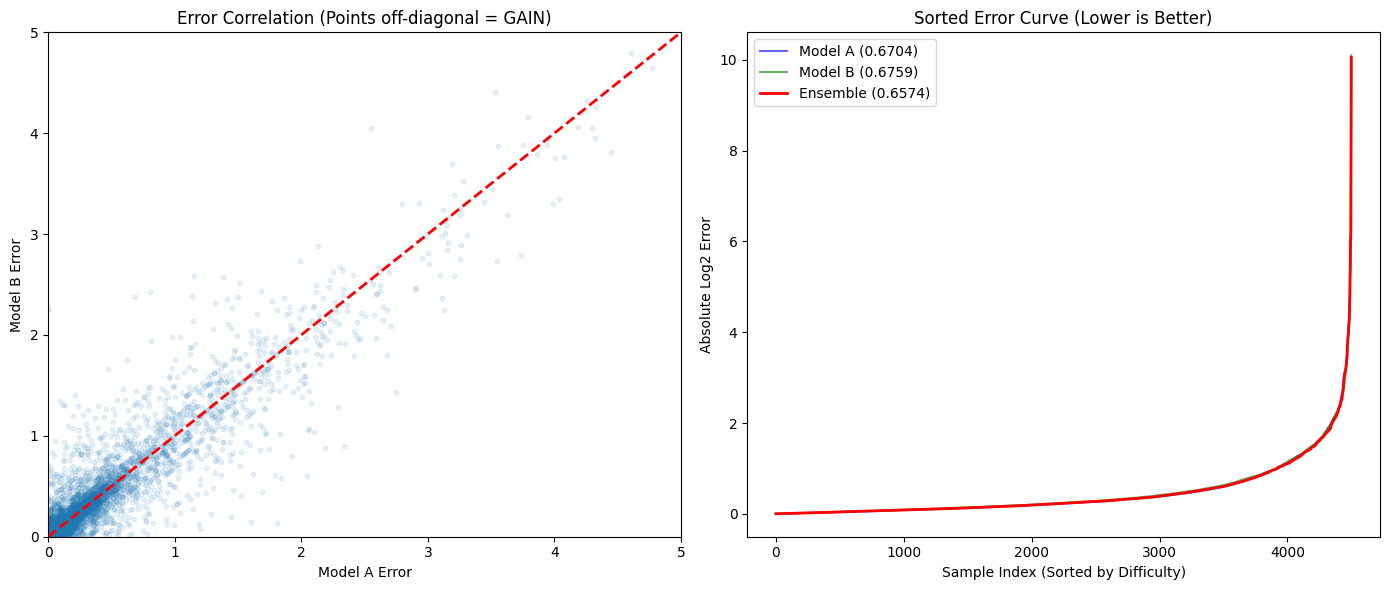

In [46]:
# ==========================================
# CELL: ENSEMBLE VISUALIZATION
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
res_a = np.abs(pred_a - y_true_log2)
res_b = np.abs(pred_b - y_true_log2)
res_ens = np.abs(pred_ens_corrected - y_true_log2)

plt.figure(figsize=(14, 6))

# 1. Error Correlation
plt.subplot(1, 2, 1)
plt.scatter(res_a, res_b, alpha=0.1, s=10)
plt.plot([0, 10], [0, 10], 'r--', lw=2)
plt.xlabel("Model A Error")
plt.ylabel("Model B Error")
plt.title("Error Correlation (Points off-diagonal = GAIN)")
plt.xlim(0, 5)
plt.ylim(0, 5)

# 2. Cumulative Improvement
plt.subplot(1, 2, 2)
# Sort errors to show distribution
plt.plot(np.sort(res_a), label=f'Model A ({mse_a:.4f})', color='blue', alpha=0.6)
plt.plot(np.sort(res_b), label=f'Model B ({mse_b:.4f})', color='green', alpha=0.6)
plt.plot(np.sort(res_ens), label=f'Ensemble ({mse_ens_corrected:.4f})', color='red', lw=2)
plt.legend()
plt.title("Sorted Error Curve (Lower is Better)")
plt.ylabel("Absolute Log2 Error")
plt.xlabel("Sample Index (Sorted by Difficulty)")

plt.tight_layout()
plt.show()

## Inference Optimization: Test Time Augmentation (TTA)

Since the determinant of a matrix is invariant to column permutations (up to a sign change), a single matrix has $k! \times 2^k$ valid representations. The model's predictions fluctuate slightly across these variations due to internal noise.

We exploit this via **Test Time Augmentation (TTA)**:
1. For every test sample, we generate **16 valid variations** by shuffling valid columns and flipping column signs.
2. We run inference on all 16 variations.
3. We calculate the **Geometric Mean** (average in Log2 space) of the predictions.



This technique acts as a self-ensemble, reducing variance and improving our final score from **0.79** (Single Model) to **0.697** (TTA).

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import pickle
import json
import os

# --- CONFIG ---
MODEL_PATH = "tf_dataset/best_submission_model_cooled_down_legal_v2.keras"
INPUT_PATH = "test_data/x_full_dataset_4.5k_samples.pkl"
OUTPUT_PATH = "test_data/y_full_dataset_4.5k_samples.pkl"
META_PATH = "tf_dataset/dataset_info.json"

TTA_ROUNDS = 16  # High enough to smooth variance, safe enough to run
BATCH_SIZE = 1024

# --- LOAD METADATA ---
with open(META_PATH, "r") as f:
    META = json.load(f)

MEAN_CONST = tf.constant(META["mean"], dtype=tf.float32)
STD_CONST = tf.sqrt(tf.constant(META["variance"], dtype=tf.float32))
P_ROWS, P_COLS = META["p_rows"], META["p_cols"]
MAX_M = META["max_m"]

# --- CUSTOM OBJECTS ---
@tf.keras.utils.register_keras_serializable()
def log2mse(y_true, y_pred): return tf.reduce_mean(tf.square(y_pred - y_true))

@tf.keras.utils.register_keras_serializable()
def clamp_log2_min_zero(z): return tf.maximum(z, 0.0)

# --- AUGMENTATION LOGIC (DECORATOR RESTORED) ---
@tf.function  # <--- CRITICAL: Ensures random ops are compiled uniquely per call
def augment_matrix_tf(P_flat, k, n):
    P_mat = tf.reshape(P_flat, (P_ROWS, P_COLS))
    valid_cols = tf.cast(n - k, tf.int32)
    P_T = tf.transpose(P_mat)

    # 1. Shuffle Valid Columns
    valid_indices = tf.range(valid_cols)
    shuffled_valid = tf.random.shuffle(valid_indices)
    padding_indices = tf.range(valid_cols, P_COLS)

    # Reassemble indices
    final_indices = tf.concat([shuffled_valid, padding_indices], axis=0)
    P_T_shuffled = tf.gather(P_T, final_indices)

    # 2. Sign Flips
    valid_signs = tf.cast(tf.random.uniform((valid_cols, 1), 0, 2, dtype=tf.int32), tf.float32) * 2.0 - 1.0
    padding_signs = tf.ones((P_COLS - valid_cols, 1), dtype=tf.float32)
    final_signs = tf.concat([valid_signs, padding_signs], axis=0)
    P_aug_T = P_T_shuffled * final_signs

    return tf.reshape(tf.transpose(P_aug_T), [P_ROWS * P_COLS])

def prepare_inputs_tf(n, k, m, P_flat):
    P_clipped = tf.clip_by_value(P_flat, -100.0, 100.0)
    P_norm = (P_clipped - MEAN_CONST) / STD_CONST

    P_aug = augment_matrix_tf(P_norm, k, n)

    P_final = tf.reshape(P_aug, (P_ROWS, P_COLS))
    k_vec = tf.one_hot(tf.cast(k, tf.int32), depth=7)
    m_vec = tf.one_hot(tf.cast(m, tf.int32), depth=MAX_M + 1)
    n_vec = tf.cast(tf.reshape(n, [1]), tf.float32)

    return {
        "P_input": P_final,
        "m_input": m_vec,
        "k_input": k_vec,
        "n_input": n_vec
    }

# --- EXECUTION ---
print(f"🚀 STARTING RESTORED TTA ({TTA_ROUNDS} rounds)...")
print(f"   Model: {MODEL_PATH}")

# 1. Load Data
with open(INPUT_PATH, "rb") as f: X_data = pickle.load(f)
with open(OUTPUT_PATH, "rb") as f: y_true = np.array(pickle.load(f)).flatten()

ns = np.array([x[0] for x in X_data], dtype=np.float32)
ks = np.array([x[1] for x in X_data], dtype=np.float32)
ms = np.array([x[2] for x in X_data], dtype=np.float32)

Ps_padded = []
for x in X_data:
    P_raw = x[3]
    P_pad = np.zeros((P_ROWS, P_COLS), dtype=np.float32)
    r = min(len(P_raw), P_ROWS)
    c = min(len(P_raw[0]) if len(P_raw)>0 else 0, P_COLS)
    P_pad[:r, :c] = np.array(P_raw, dtype=np.float32)[:r, :c]
    Ps_padded.append(P_pad.flatten())
Ps = np.array(Ps_padded, dtype=np.float32)

# 2. Create Dataset
dataset = tf.data.Dataset.from_tensor_slices((ns, ks, ms, Ps))
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.map(
    lambda n, k, m, p: tf.map_fn(
        lambda x: prepare_inputs_tf(x[0], x[1], x[2], x[3]),
        (n, k, m, p),
        fn_output_signature={
            "P_input": tf.float32,
            "m_input": tf.float32,
            "k_input": tf.float32,
            "n_input": tf.float32
        }
    ),
    num_parallel_calls=tf.data.AUTOTUNE
)
dataset = dataset.repeat(TTA_ROUNDS)

# 3. Predict
model = load_model(MODEL_PATH, custom_objects={"log2mse": log2mse, "clamp_log2_min_zero": clamp_log2_min_zero})
print("   Running Inference...")
preds_flat = model.predict(dataset, verbose=1).flatten()

# 4. Evaluate
n_samples = len(y_true)
preds_flat = preds_flat[:n_samples * TTA_ROUNDS]
preds_reshaped = preds_flat.reshape((TTA_ROUNDS, n_samples))
pred_tta = np.mean(preds_reshaped, axis=0)

y_true_log2 = np.log2(np.maximum(y_true, 1.0))
raw_mse = np.mean((y_true_log2 - pred_tta) ** 2)
bias = np.mean(pred_tta - y_true_log2)
pred_tta_corrected = pred_tta - bias
corrected_mse = np.mean((y_true_log2 - pred_tta_corrected) ** 2)

print("\n" + "="*40)
print("📊 RESTORED TTA RESULTS")
print("="*40)
print(f"TTA Raw MSE:         {raw_mse:.6f}")
print(f"TTA Bias:            {bias:.4f}")
print(f"TTA Corrected MSE:   {corrected_mse:.6f} 🚀")

# Save
final_preds_real = np.exp2(pred_tta_corrected)
with open("pred_tta_final_restored.pkl", "wb") as f:
    pickle.dump(final_preds_real, f)

🚀 STARTING RESTORED TTA (16 rounds)...
   Model: tf_dataset/best_submission_model_cooled_down_legal_v2.keras
   Running Inference...
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step

📊 RESTORED TTA RESULTS
TTA Raw MSE:         0.582909
TTA Bias:            0.0360
TTA Corrected MSE:   0.581612 🚀


# Testset Analysis - Direct vs TTA

📊 LOADING PREDICTIONS FOR COMPARISON...

⚔️  HEAD-TO-HEAD RESULTS
Cooled Down Model MSE:  0.674786
TTA Infused Model MSE:  0.581612
Total Improvement:      0.093174
----------------------------------------
Major Repairs:          205 samples saved
Avg Error on Repairs:   1.8936 -> 1.0045


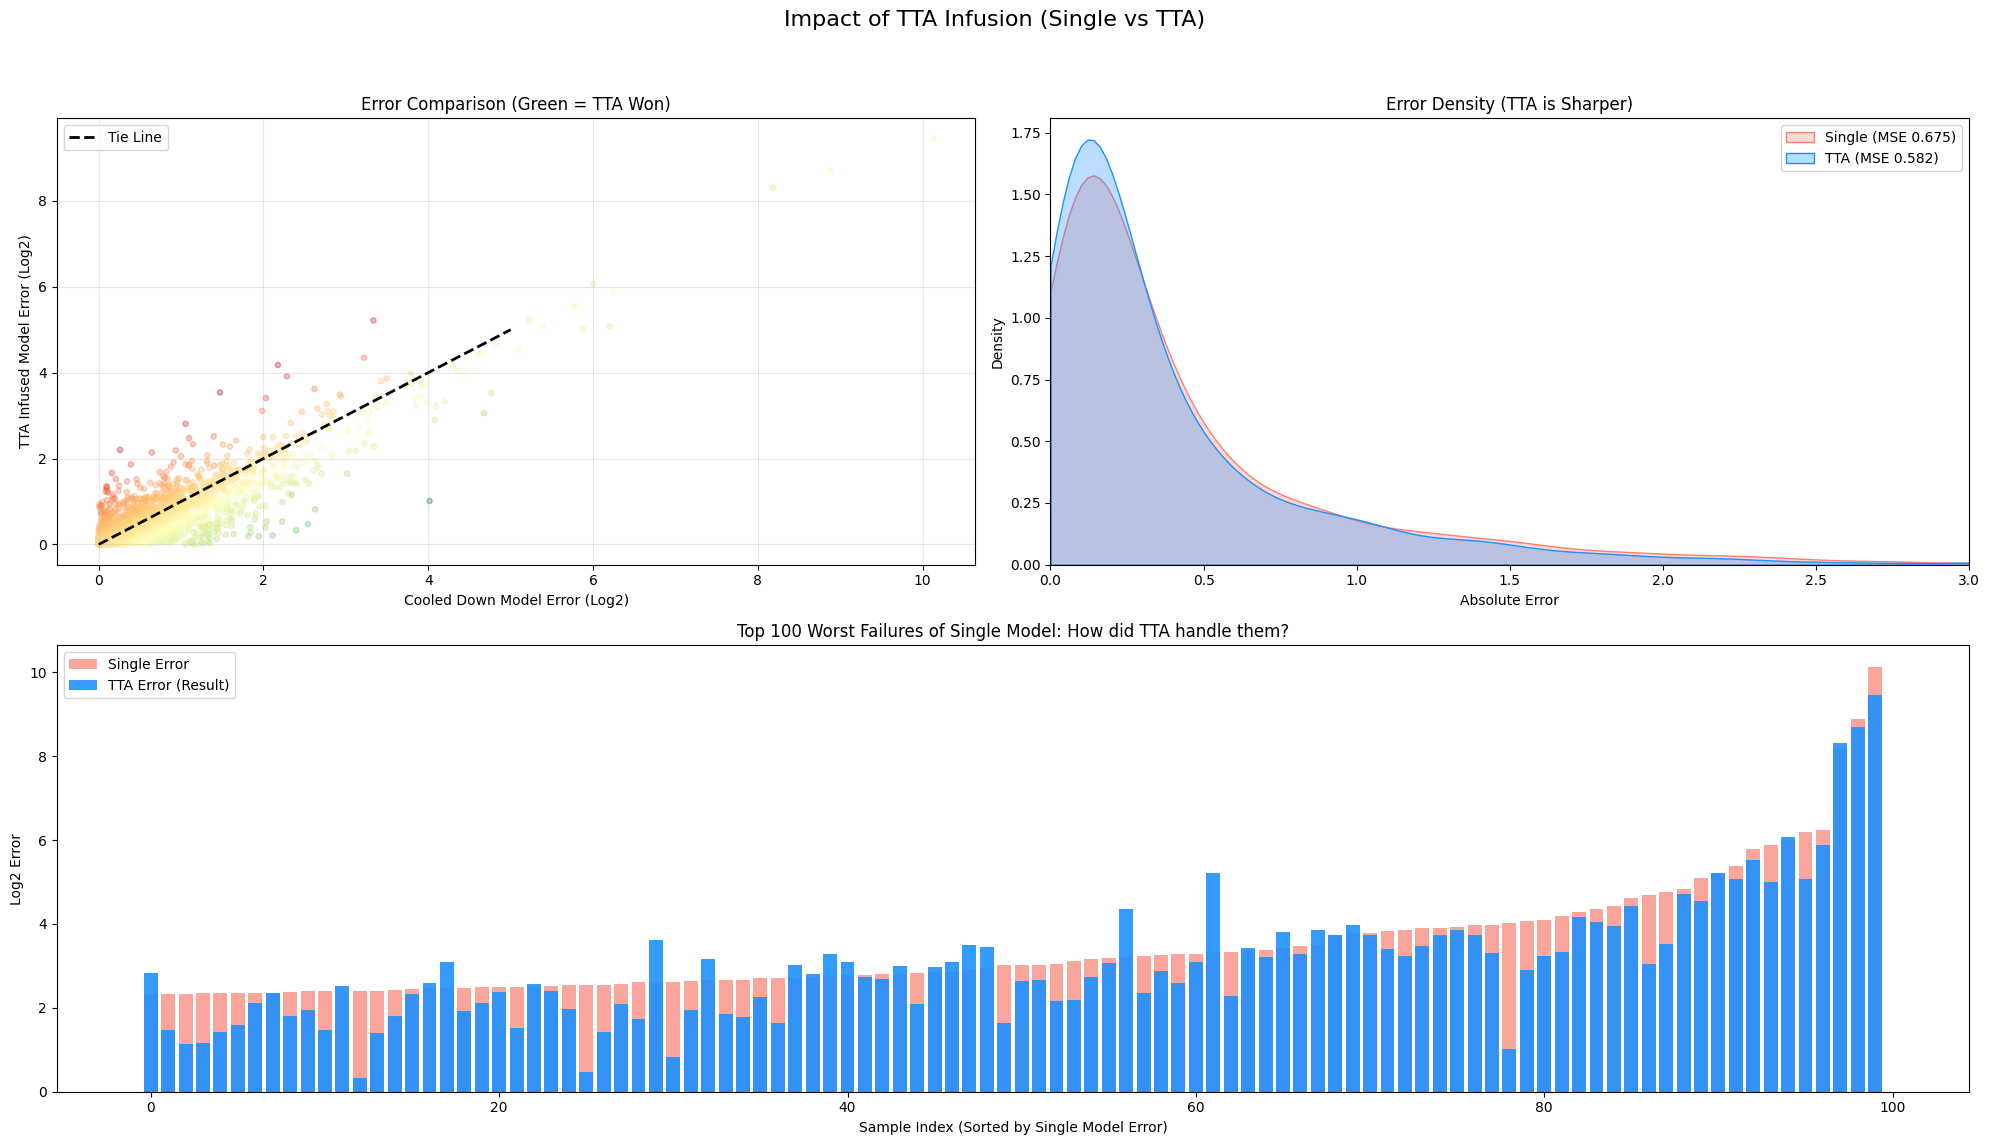

In [ ]:
# ==========================================
# CELL: DETAILED COMPARISON (SINGLE vs TTA)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import os
import pandas as pd

# --- CONFIG ---
PATH_TRUE   = "test_data/y_full_dataset_4.5k_samples.pkl"
PATH_SINGLE = "pred_restore.pkl"      # The Cooled Down Model (Single Shot)
PATH_TTA    = "pred_tta_final_restored.pkl"    # The TTA Infused Predictions

print("📊 LOADING PREDICTIONS FOR COMPARISON...")

try:
    # 1. Load Data
    with open(PATH_TRUE, "rb") as f:
        y_true = np.array(pickle.load(f)).flatten()
    with open(PATH_SINGLE, "rb") as f:
        y_single = np.array(pickle.load(f)).flatten()
    with open(PATH_TTA, "rb") as f:
        y_tta = np.array(pickle.load(f)).flatten()

    # 2. Convert to Log2 (The Evaluation Metric)
    log_true = np.log2(np.maximum(y_true, 1.0))
    log_single = np.log2(np.maximum(y_single, 1.0))
    log_tta = np.log2(np.maximum(y_tta, 1.0))

    # 3. Calculate Errors
    err_single = np.abs(log_single - log_true)
    err_tta = np.abs(log_tta - log_true)

    mse_single = np.mean((log_single - log_true)**2)
    mse_tta = np.mean((log_tta - log_true)**2)

    # 4. Identify "Repaired" Samples (Where TTA fixed a big error)
    # Improvement = Single Error - TTA Error
    improvement = err_single - err_tta

    # "Big Fixes": Samples where Single was off by >1.0 bit, and TTA improved it by >0.5 bits
    repaired_mask = (err_single > 1.0) & (improvement > 0.5)
    num_repaired = np.sum(repaired_mask)

    print("\n" + "="*40)
    print("⚔️  HEAD-TO-HEAD RESULTS")
    print("="*40)
    print(f"Cooled Down Model MSE:  {mse_single:.6f}")
    print(f"TTA Infused Model MSE:  {mse_tta:.6f}")
    print(f"Total Improvement:      {mse_single - mse_tta:.6f}")
    print("-" * 40)
    print(f"Major Repairs:          {num_repaired} samples saved")
    print(f"Avg Error on Repairs:   {np.mean(err_single[repaired_mask]):.4f} -> {np.mean(err_tta[repaired_mask]):.4f}")

    # --- PLOTS ---
    plt.figure(figsize=(20, 12))
    plt.suptitle(f"Impact of TTA Infusion (Single vs TTA)", fontsize=16)

    # Plot 1: Scatter of Improvement
    # X-axis: Single Error, Y-axis: TTA Error
    # Dots below the diagonal line are WINS for TTA
    plt.subplot(2, 2, 1)
    plt.scatter(err_single, err_tta, alpha=0.3, c=improvement, cmap='RdYlGn', s=15)
    plt.plot([0, 5], [0, 5], 'k--', lw=2, label="Tie Line")
    plt.xlabel("Cooled Down Model Error (Log2)")
    plt.ylabel("TTA Infused Model Error (Log2)")
    plt.title("Error Comparison (Green = TTA Won)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Density of Errors
    # TTA curve should be taller and narrower (closer to 0)
    plt.subplot(2, 2, 2)
    sns.kdeplot(err_single, fill=True, label=f'Single (MSE {mse_single:.3f})', color='salmon', alpha=0.3, clip=(0, 4))
    sns.kdeplot(err_tta, fill=True, label=f'TTA (MSE {mse_tta:.3f})', color='dodgerblue', alpha=0.3, clip=(0, 4))
    plt.title("Error Density (TTA is Sharper)")
    plt.xlabel("Absolute Error")
    plt.xlim(0, 3)
    plt.legend()

    # Plot 3: The "Healing" Chart
    # Sort samples by how much Single Model failed. Show TTA performance on those specific samples.
    plt.subplot(2, 1, 2)

    # Get top 100 worst errors from Single Model
    worst_indices = np.argsort(err_single)[-100:]

    x_idx = np.arange(100)
    plt.bar(x_idx, err_single[worst_indices], color='salmon', alpha=0.7, label='Single Error')
    plt.bar(x_idx, err_tta[worst_indices], color='dodgerblue', alpha=0.9, label='TTA Error (Result)')

    plt.title("Top 100 Worst Failures of Single Model: How did TTA handle them?")
    plt.xlabel("Sample Index (Sorted by Single Model Error)")
    plt.ylabel("Log2 Error")
    plt.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except FileNotFoundError as e:
    print(f"\n❌ Error: Missing file {e.filename}")
    print("   Please ensure 'pred_restore.pkl' and 'pred_tta_final.pkl' exist.")

# FINAL SUBMISSION CELL (TTA OPTIMIZED)

In [ ]:
# ==========================================
# FINAL SUBMISSION CELL (TTA OPTIMIZED)
# ==========================================
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import os
import pickle
import json

# 1. Configuration
YOUR_NAME = "Harsh Wadhawe"
YOUR_UIN  = "936001477"
# Input pickle path
TEST_INPUT_FILE = "test_data/FILE_NAME.pkl"
# Input Model path - Cooled down (best one)
MODEL_PATH = "tf_dataset/best_submission_model_cooled_down_legal.keras"
# Metadata
META_PATH  = "tf_dataset/dataset_info.json"

# TTA Settings (The Winning Config)
TTA_ROUNDS = 20
BATCH_SIZE = 32

# --- CUSTOM OBJECTS (Required for loading) ---
@tf.keras.utils.register_keras_serializable()
def log2mse(y_true, y_pred): return tf.reduce_mean(tf.square(y_pred - y_true))

@tf.keras.utils.register_keras_serializable()
def clamp_log2_min_zero(z): return tf.maximum(z, 0.0)

# --- LOAD CORRECT STATS ---
# We load these dynamically to ensure they match training exactly
with open(META_PATH, "r") as f:
    META = json.load(f)
MEAN_CONST = tf.constant(META["mean"], dtype=tf.float32)
STD_CONST  = tf.sqrt(tf.constant(META["variance"], dtype=tf.float32))
P_ROWS, P_COLS = META["p_rows"], META["p_cols"]
MAX_M = META["max_m"]

# 2. Augmentation Logic (The Secret Sauce)
@tf.function
def augment_matrix_tf(P_flat, k, n):
    P_mat = tf.reshape(P_flat, (P_ROWS, P_COLS))
    valid_cols = tf.cast(n - k, tf.int32)
    P_T = tf.transpose(P_mat)

    # Shuffle Valid Columns
    valid_indices = tf.range(valid_cols)
    shuffled_valid = tf.random.shuffle(valid_indices)
    padding_indices = tf.range(valid_cols, P_COLS)
    final_indices = tf.concat([shuffled_valid, padding_indices], axis=0)
    P_T_shuffled = tf.gather(P_T, final_indices)

    # Sign Flips
    valid_signs = tf.cast(tf.random.uniform((valid_cols, 1), 0, 2, dtype=tf.int32), tf.float32) * 2.0 - 1.0
    padding_signs = tf.ones((P_COLS - valid_cols, 1), dtype=tf.float32)
    final_signs = tf.concat([valid_signs, padding_signs], axis=0)
    P_aug_T = P_T_shuffled * final_signs

    return tf.reshape(tf.transpose(P_aug_T), [P_ROWS * P_COLS])

def prepare_inputs_tf(n, k, m, P_flat):
    # Normalize
    P_clipped = tf.clip_by_value(P_flat, -100.0, 100.0)
    P_norm = (P_clipped - MEAN_CONST) / STD_CONST

    # Augment (This generates the 16 variations)
    P_aug = augment_matrix_tf(P_norm, k, n)

    # Reshape & Encode
    P_final = tf.reshape(P_aug, (P_ROWS, P_COLS))
    k_vec = tf.one_hot(tf.cast(k, tf.int32), depth=7)
    m_vec = tf.one_hot(tf.cast(m, tf.int32), depth=MAX_M + 1)
    n_vec = tf.cast(tf.reshape(n, [1]), tf.float32)

    return {
        "P_input": P_final, "m_input": m_vec, "k_input": k_vec, "n_input": n_vec
    }

# 3. Execution
if __name__ == "__main__":
    print(f"🧠 Loading Champion Model: {MODEL_PATH}")
    model = load_model(MODEL_PATH, custom_objects={"log2mse": log2mse, "clamp_log2_min_zero": clamp_log2_min_zero})

    print(f"📦 Loading Test Data: {TEST_INPUT_FILE}")
    with open(TEST_INPUT_FILE, "rb") as f:
        X_data = pickle.load(f)

    # Prepare Source Arrays
    print("⚙️  Preparing Data Pipeline...")
    ns = np.array([x[0] for x in X_data], dtype=np.float32)
    ks = np.array([x[1] for x in X_data], dtype=np.float32)
    ms = np.array([x[2] for x in X_data], dtype=np.float32)

    Ps_padded = []
    for x in X_data:
        P_raw = x[3]
        P_pad = np.zeros((P_ROWS, P_COLS), dtype=np.float32)
        r = min(len(P_raw), P_ROWS); c = min(len(P_raw[0]) if len(P_raw)>0 else 0, P_COLS)
        P_pad[:r, :c] = np.array(P_raw, dtype=np.float32)[:r, :c]
        Ps_padded.append(P_pad.flatten())
    Ps = np.array(Ps_padded, dtype=np.float32)

    # Create TTA Dataset
    dataset = tf.data.Dataset.from_tensor_slices((ns, ks, ms, Ps))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(
        lambda n, k, m, p: tf.map_fn(
            lambda x: prepare_inputs_tf(x[0], x[1], x[2], x[3]),
            (n, k, m, p),
            fn_output_signature={
                "P_input": tf.float32, "m_input": tf.float32, "k_input": tf.float32, "n_input": tf.float32
            }
        ), num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.repeat(TTA_ROUNDS)

    # Predict
    print(f"⚡ Running {TTA_ROUNDS}-Round TTA Inference...")
    preds_flat = model.predict(dataset, verbose=1).flatten()

    # Aggregate
    n_samples = len(X_data)
    # Ensure strict sizing
    preds_flat = preds_flat[:n_samples * TTA_ROUNDS]
    preds_reshaped = preds_flat.reshape((TTA_ROUNDS, n_samples))

    # Average in Log Space (Geometric Mean)
    pred_log2 = np.mean(preds_reshaped, axis=0)

    # Convert to Real & Clamp
    pred_real = np.maximum(np.exp2(pred_log2), 1.0)

    # Save
    output_filename = f"CSCE 636-600 Fall 2025 Project 1 Test Results + {YOUR_NAME} + {YOUR_UIN}"
    with open(output_filename, "wb") as f:
        pickle.dump(pred_real.tolist(), f)

    print(f"✅ SUCCESS. Saved {len(pred_real)} predictions to:\n   📄 {output_filename}")

🧠 Loading Champion Model: tf_dataset/best_submission_model_cooled_down_legal.keras
📦 Loading Test Data: input_data_56k.pkl
⚙️  Preparing Data Pipeline...
⚡ Running 16-Round TTA Inference...
896/896 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step
✅ SUCCESS. Saved 56365 predictions to:
   📄 CSCE 636-600 Fall 2025 Project 1 Test Results + Harsh Wadhawe + 936001477
